# Visión por Computadora I - 2025 - B3 - Trabajo práctico 2
**Inteligencia Artificial - CEIA - FIUBA**

## Autores

- **Mendoza Dante**.
- **Vasquez Jorge**.
- **Viñas Gustavo**.

# 💻 TP2 - Objetivo

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas.  
El video a procesar será: “focus_video.mov”.

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame. Área de la ROI = 5 o 10% del área total del frame.
    3. (Opcional) Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc… (al menos 3)  
  
    Para cada experimento se debe presentar :
      - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shape from focus.  
3. (Puntos extra) Aplicar unsharp masking para expandir la zona de enfoque y recalcular la métrica.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### 1. Implementación del algoritmo

In [2]:
def image_quality_measure(I: np.ndarray) -> float:
    """
    Calculate image quality measure

    Parameters
    ---------
    I (np.ndarray)
        Source image
    
    Returns
    ---------
    FM (float)
        Image Quality Measure for input image
    """
    if (I.ndim != 2): raise Exception("Only 2D (gray) images allowed.")
    # step 1 - compute fast fourier transform (fft) representation of source image
    F = np.fft.fft2(I)
    # step 2 - shift origin of fft to centre
    Fc = np.fft.fftshift(F)
    # step 3 - calculate absolute value of the centered fft
    AF = np.abs(Fc)
    # step 4 - calculate max value of absolute fft
    M = np.max(AF)
    # step 5 - calculate threshold and total number of pixels in fft image whose pixel value is above threshold
    thres = M / 1000
    T_h = np.sum(AF > thres)
    FM = T_h / I.size
    return FM

In [3]:
# Test algorithm 
img_lena = cv2.imread('./img/lena_std.tif', cv2.IMREAD_GRAYSCALE)
print(f"Lena IQM (FM): {image_quality_measure(img_lena):.4f}")


Lena IQM (FM): 0.0182


Funciones para el procesamiento del video y gráficos

In [4]:
from collections.abc import Callable
def process_video(video_path: str, frame_func, **kwargs) -> list[float]:
    """
    Abre y recorre un video frame por frame, invocando a la funcion frame_func por cada frame.
    Guarda el resultado de frame_func en un array que es retornado como resultado

    Parameters
    ---------
    video_path (str)
        Ruta al video
    frame_func (Callable[[np.ndarray], float])
        Función que se invoca por cada frame.
        Debe aceptar la imagen del frame como np.ndarray.
        Debe retornar el valor del procesamiento del frame como float.
    
    Returns
    ---------
    (list[float])
        Array de resultados obtenidos por el procesamiento de cada frame

    """
    video = cv2.VideoCapture(video_path)
    if not video.isOpened(): raise Exception("Error al abrir el archivo de video")

    try:
        res_array = []
        while True:
            ret, frame = video.read()
            if not ret: break
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            single_frame_res = frame_func(frame_gris, **kwargs)
            res_array.append(single_frame_res)
        
        return res_array
    finally:
        video.release()

def percentile_calc(frame_analysis: list[float], percentile_min: int, percentile_max: int | None = None) -> tuple[list[int], list[float], float, float | None]:
    """
    Función auxiliar para calcular los frames con valores entre los percentiles percentile_min y percentile_max.

    Parameters
    ---------
    frame_analysis (list[float])
        Lista frames que se analizarán
    percentile_min (int)
        Percentil inferior para analizar los frames.
    percentile_max (int)
        Percentil superior para analizar los frames. Si no se establece, se ignora la cota superior.

    Returns
    ---------
    x (list[int])
        Lista de los frames entre los percentiles indicados
    y (list[float])
        Lista de los valores de los frames entre los percentiles indicados
    perc_min (float)
        Valor del percentil mínimo
    perc_max (float)
        Valor del percentil máximo
    """
    perc_min = float(np.percentile(frame_analysis, percentile_min))
    perc_max = float(np.percentile(frame_analysis, percentile_max)) if (not percentile_max is None) else None
    x = []
    y = []
    for i,v in enumerate(frame_analysis):
        if v > perc_min and (perc_max is None or v < perc_max):
            x.append(i)
            y.append(v)
    return x, y, perc_min, perc_max

def plot_comparative(elements: list[list[float]], labels: list[str], figsize: list[int], colors: list[str]) -> list[tuple[int, str]]:
    """
    Función auxiliar para graficar varios arrays uno al lado del otro y una comparativa de todos debajo.

    Parameters
    ---------
    elements (list[list[float]])
        Lista de arrays que se graficarán
    labels (list[str])
        Lista de labels para cada array.
    figsize (list[int])
        Tamaño del gráfico completo.
    colors (list[str])
        Colores aplicados a cada array graficado.
    """
    top_frames = []
    plt.figure(figsize=figsize)
    axn=plt.subplot(212)
    for x in range(len(elements)):
        ax=plt.subplot(200 + len(elements) * 10 + x + 1)
        ax.plot(elements[x], marker='o', linestyle='-', color=colors[x], zorder=5, markersize=3)
        max_frame = int(np.argmax(elements[x]))
        top_frames.append((max_frame, labels[x]))
        ax.axvline(max_frame, color=colors[x], zorder=1)
        ax.text(max_frame, ax.get_ylim()[0], str(max_frame))
        ax.text(max_frame, elements[x][max_frame], f"{elements[x][max_frame]:.3f}")
        ax.set_xlabel("Frame #")
        ax.set_ylabel("Score")
        ax.set_title(label=labels[x])
        ax.grid(True)
        perc_x, perc_y, perc_v, _ = percentile_calc(elements[x], 85)
        ax.plot(perc_x, perc_y, marker='x', linestyle='', color="black", markersize=2, zorder=10)
        ax.axhline(perc_v, color=colors[x], zorder=1)
        ax.text(0, perc_v, f"85%: {perc_v:.3f}")

        axn.plot(elements[x], marker='o', linestyle='-', color=colors[x], label=labels[x], markersize=3)
        axn.axvline(max_frame, color=colors[x])
        axn.text(max_frame, axn.get_ylim()[0], str(max_frame))
        axn.text(max_frame, elements[x][max_frame], f"{elements[x][max_frame]:.3f}")
        axn.plot(perc_x, perc_y, marker='x', linestyle='', color="black", markersize=2, zorder=10)
        axn.axhline(perc_v, color=colors[x], zorder=1)
        axn.text(0, perc_v, f"85%: {perc_v:.3f}")
    axn.set_xlabel("Frame #")
    axn.set_ylabel("Score")
    axn.set_title(r"Comparative")
    axn.legend()
    plt.tight_layout()
    axn.grid(True)
    return top_frames

>  1. Medición sobre todo el frame

In [5]:
def full_frame_analysis(frame: np.ndarray, measure_func) -> float:
    """
    Funcion que analiza el frame completo con el algoritmo measure_func.

    Parameters
    ---------
    frame (np.ndarray)
        Frame que se analizará.
    
    Returns
    ---------
    (float)
        Resultado del analisis del frame
    """
    return measure_func(frame)

In [6]:
video_path = "./video/focus_video.mov"
full_frame_iqm = process_video(video_path, full_frame_analysis, measure_func=image_quality_measure)
top_frames = []

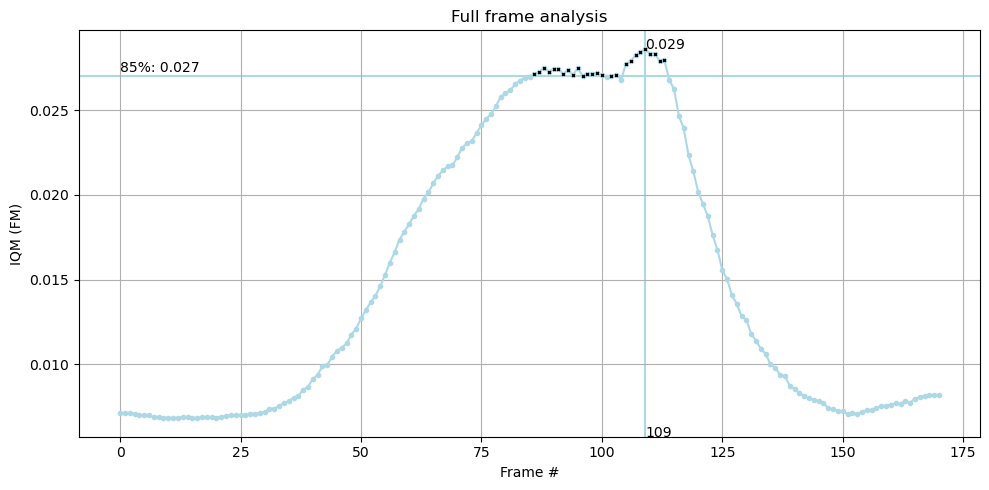

In [7]:
plt.figure(figsize=(10,5))
plt.plot(full_frame_iqm, marker='o', linestyle='-', color="lightblue", zorder=5, markersize=3)
max_frame = int(np.argmax(full_frame_iqm))
plt.axvline(max_frame, color="lightblue", zorder=1)
plt.text(max_frame, plt.ylim()[0], str(max_frame))
plt.text(max_frame, full_frame_iqm[max_frame], f"{full_frame_iqm[max_frame]:.3f}")
perc_x, perc_y, perc_v, _ = percentile_calc(full_frame_iqm, 85)
plt.plot(perc_x, perc_y, marker='x', linestyle='', color="black", markersize=2, zorder=10)
plt.axhline(perc_v, color="lightblue", zorder=1)
plt.text(0, perc_v * 1.01, f"85%: {perc_v:.3f}")
plt.xlabel("Frame #")
plt.ylabel("IQM (FM)")
plt.title("Full frame analysis")
plt.grid(True)
plt.tight_layout()
plt.show()
top_frames.append((max_frame, "Full frame analysis"))

Según el análisis del frame completo, el foco óptimo estaría en el frame 109, aunque muestra una zona a partir del frame 90 aprox con buen foco (top 85% de mejores valores).  
Dentro esa zona hay algunos puntos por debajo del 85%, pero muy cercanos, no parece una perdida de foco importante, aunque quedan fuera del 85%.

Nota: Sobre los gráficos, cuando se menciona top 85% se hace referencia a los 26 frames con mejor foco, indicados con un punto en cada gráfico.

>  2. Medición sobre una ROI centrada de 10% y 5%

In [8]:
def roi_frame_analysis(frame: np.ndarray, roi: float, measure_func) -> float:
    """
    Funcion que analiza el frame con el algoritmo measure_func
    utilizando solo la región central definida por el % de ROI sobre 
    el área total de la imagen.

    Parameters
    ---------
    frame (np.ndarray)
        Frame que se analizará.
    roi (float)
        Porcentaje del área de imagen que se analizará, establecida en 1/100.
    
    Returns
    ---------
    (float)
        Resultado del analisis del frame
    """
    if roi > 1 or roi <= 0: raise Exception("roi value must be greater than 0 and less than 1")
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]
    # Utilizamos un cuadrado centrado cuya área es el % indicado
    # Podriamos haber utilizado % de ancho y % de alto aunque el área sería distinta
    roi_x_size = roi_y_size = np.sqrt(frame_height * frame_width * roi)

    # Si el ROI desborda en algún sentido, compenso el área sobrante hacia el otro eje.
    # Esto puede ocurrir porque el ROI se asume cuadrado y centrado.
    # Es una decisión de diseño, podría simplemente limitarse o lanzar error.
    # O podría considerarse el ROI como porcentaje sobre cada lado (aunque asi no 
    # representaría el % sobre el área total del frame)
    if (roi_x_size > frame_width):
        roi_y_size += (roi_x_size - frame_width) * roi_y_size / frame_width
        roi_x_size = frame_width
    if (roi_y_size > frame_height):
        roi_x_size += (roi_y_size - frame_height) * roi_x_size / frame_height
        roi_y_size = frame_height

    roi_x_size = int(roi_x_size)
    roi_y_size = int(roi_y_size)
    roi_x = frame_width // 2 - roi_x_size // 2
    roi_y = frame_height // 2 - roi_y_size // 2
    return measure_func(frame[roi_y:roi_y+roi_y_size,roi_x:roi_x+roi_x_size])

In [9]:
roi_frame_iqm = []
video_path = "./video/focus_video.mov"
roi_frame_iqm.append(process_video(video_path, roi_frame_analysis, roi=0.1, measure_func=image_quality_measure))
roi_frame_iqm.append(process_video(video_path, roi_frame_analysis, roi=0.05, measure_func=image_quality_measure))
roi_frame_iqm.append(process_video(video_path, roi_frame_analysis, roi=1, measure_func=image_quality_measure)) # Debe dar el mismo resultado que el punto 1 por el ajuste sobre el desborde

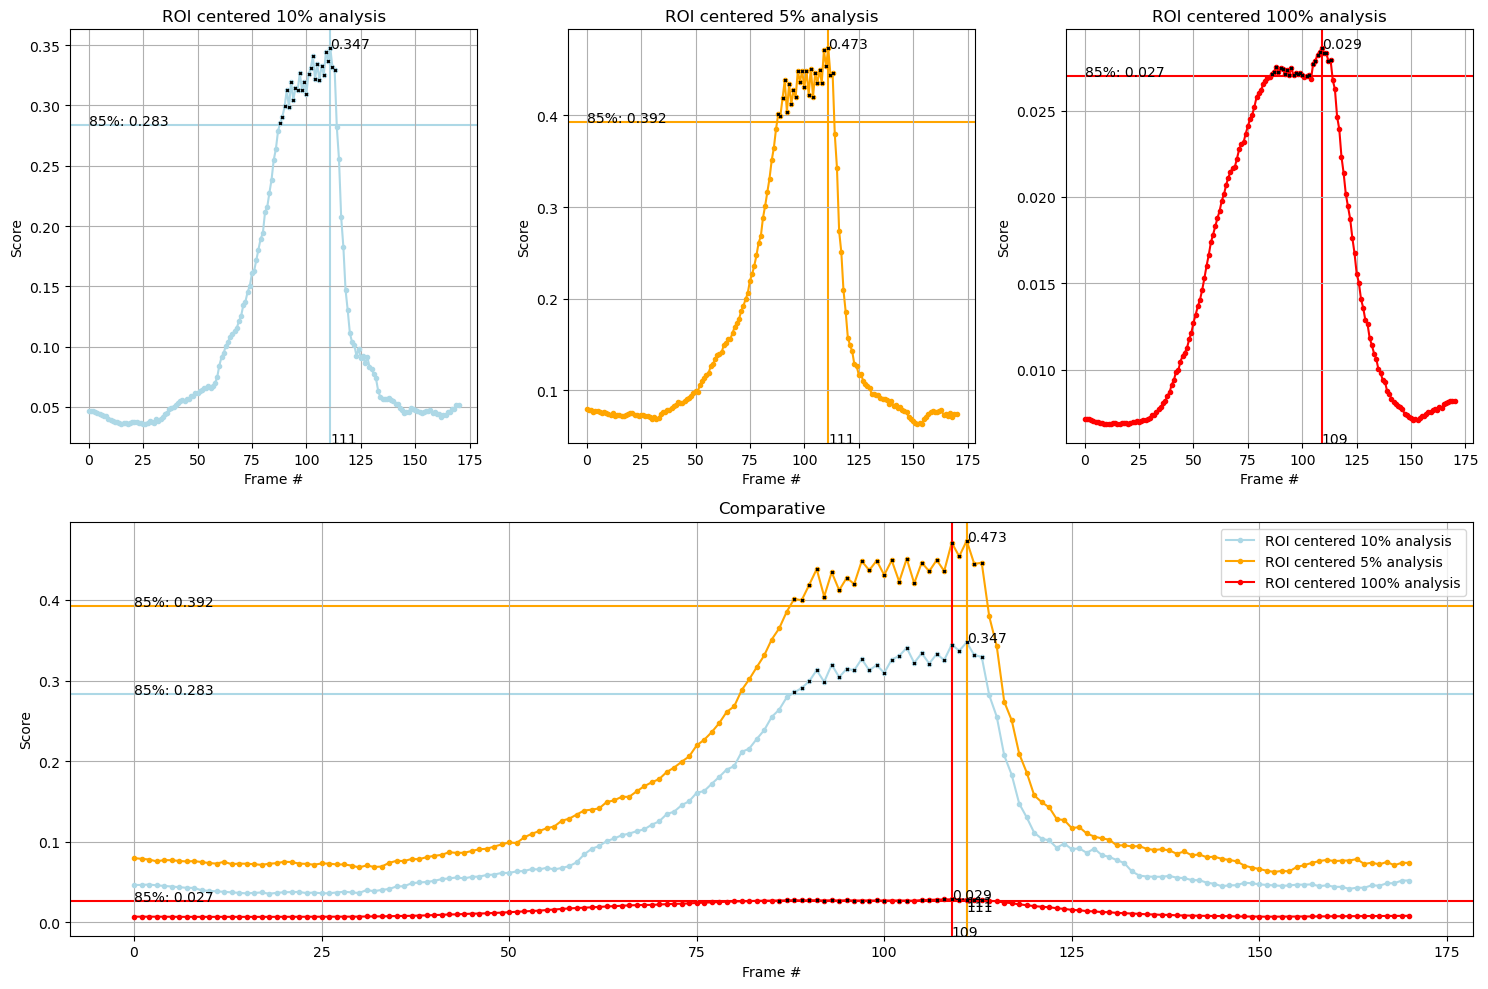

In [10]:
colors = ["lightblue", "orange", "red"]
top_frames += plot_comparative(roi_frame_iqm, [r"ROI centered 10% analysis", r"ROI centered 5% analysis", r"ROI centered 100% analysis"], [15,10], colors)

Al utilizar ROI 10% y 5% vemos que las métricas son mejores, lo que indicaría mejor enfoque, aunque la zona de buen enfoque queda muy similar (considerando el top 85% de cada medición).  
El mejor frame es el 111 para ROI 10% y 5%.  

>  3. Medición sobre una matriz de enfoque de NxM

In [11]:
video_path = "./video/focus_video.mov"

def matrix_frame_analysis(frame: np.ndarray, matrix_n: int, matrix_m: int, box_width_px: int, box_height_px: int, space_px: int, measure_func) -> float:
    """
    Funcion que analiza el frame con el algoritmo measure_func
    utilizando una matriz de NxM con áreas rectangulares de box_width_px x 
    box_height_px separadas equidistantes por space_px pixeles.

    Parameters
    ---------
    frame (np.ndarray)
        Frame que se analizará.
    matrix_n (int)
        Cantidad de áreas que se analizarán a lo ancho (N).
    matrix_m (int)
        Cantidad de áreas que se analizarán a lo alto (M).
    box_width_px (int)
        Ancho de las áreas que se analizaran, en pixeles.
    box_height_px (int)
        Alto de las áreas que se analizaran, en pixeles.
    space_px (int)
        Espacio de separación para las áreas, en pixeles.
    
    Returns
    ---------
    (float)
        Resultado del analisis del frame
    """
    if matrix_n < 1 or matrix_m < 1: raise Exception("m and n must be greater or equal than 1")
    if box_width_px < 1: raise Exception("box_width_px value must be greater than 0")
    if box_height_px < 1: raise Exception("box_height_px value must be greater than 0")
    if space_px < 1: raise Exception("space_px value must be greater than 0")

    frame_width = frame.shape[1]
    frame_height = frame.shape[0]
    roi_size_n = box_width_px * matrix_n
    space_size_n = space_px * (matrix_n - 1)
    roi_size_m = box_height_px * matrix_m
    space_size_m = space_px * (matrix_m - 1)

    # En este caso, si los ROIs sumados a los espacios exceden los límites del frame, lanzamos error.
    if (roi_size_n + space_size_n) > frame_width: raise Exception("Sum of roi sizes and space sizes exceed frame width")
    if (roi_size_m + space_size_m) > frame_height: raise Exception("Sum of roi sizes and space sizes exceed frame height")

    start_x = frame_width // 2 - roi_size_n // 2 - space_size_n // 2
    start_y = frame_height // 2 - roi_size_m // 2 - space_size_m // 2

    frame_iqm = []
    for n in range(matrix_n):
        x = start_x + n * (box_width_px + space_px)
        for m in range(matrix_m):
            y = start_y + m * space_px
            frame_iqm.append(measure_func(frame[y:y+box_height_px,x:x+box_width_px]))
    
    return float(np.mean(frame_iqm))

In [12]:
matrix_frame_iqm = []
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=1, matrix_m=1, box_width_px=151, 
                                      box_height_px=151, space_px=20, measure_func=image_quality_measure)) # Debe dar el resultado del punto 2 para roi 0.1
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=1, matrix_m=1, box_width_px=107, 
                                      box_height_px=107, space_px=20, measure_func=image_quality_measure)) # Debe dar el resultado del punto 2 para roi 0.05
# El gráfico obtenido debería ser igual al punto anterior para los casos 10% y 5%. Hecho solo para verificación.

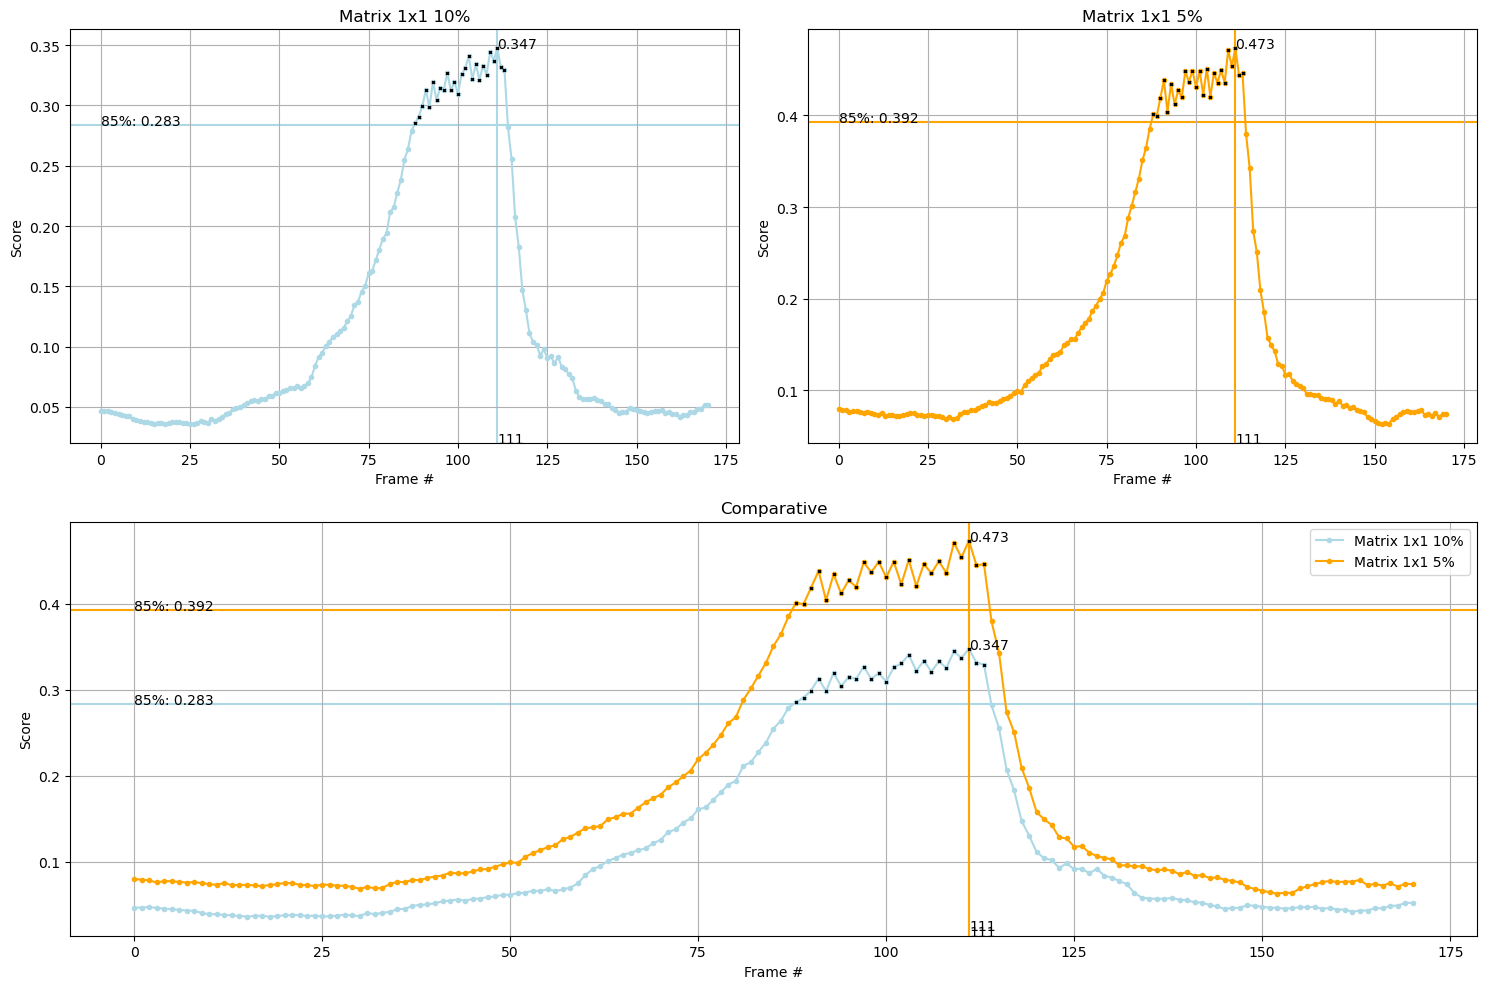

In [13]:
colors = ["lightblue", "orange"]
top_frames += plot_comparative(matrix_frame_iqm, [r"Matrix 1x1 10%", r"Matrix 1x1 5%"], [15,10], colors)

Nota: Este gráfico fue realizado solo para comparar la implementación de matrices nxm usando una matríz de 1x1.

#### Probamos otros casos

In [14]:
matrix_frame_iqm = []
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=3, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=image_quality_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=5, box_width_px=20, box_height_px=20, space_px=20, measure_func=image_quality_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=7, box_width_px=20, box_height_px=20, space_px=20, measure_func=image_quality_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=image_quality_measure))


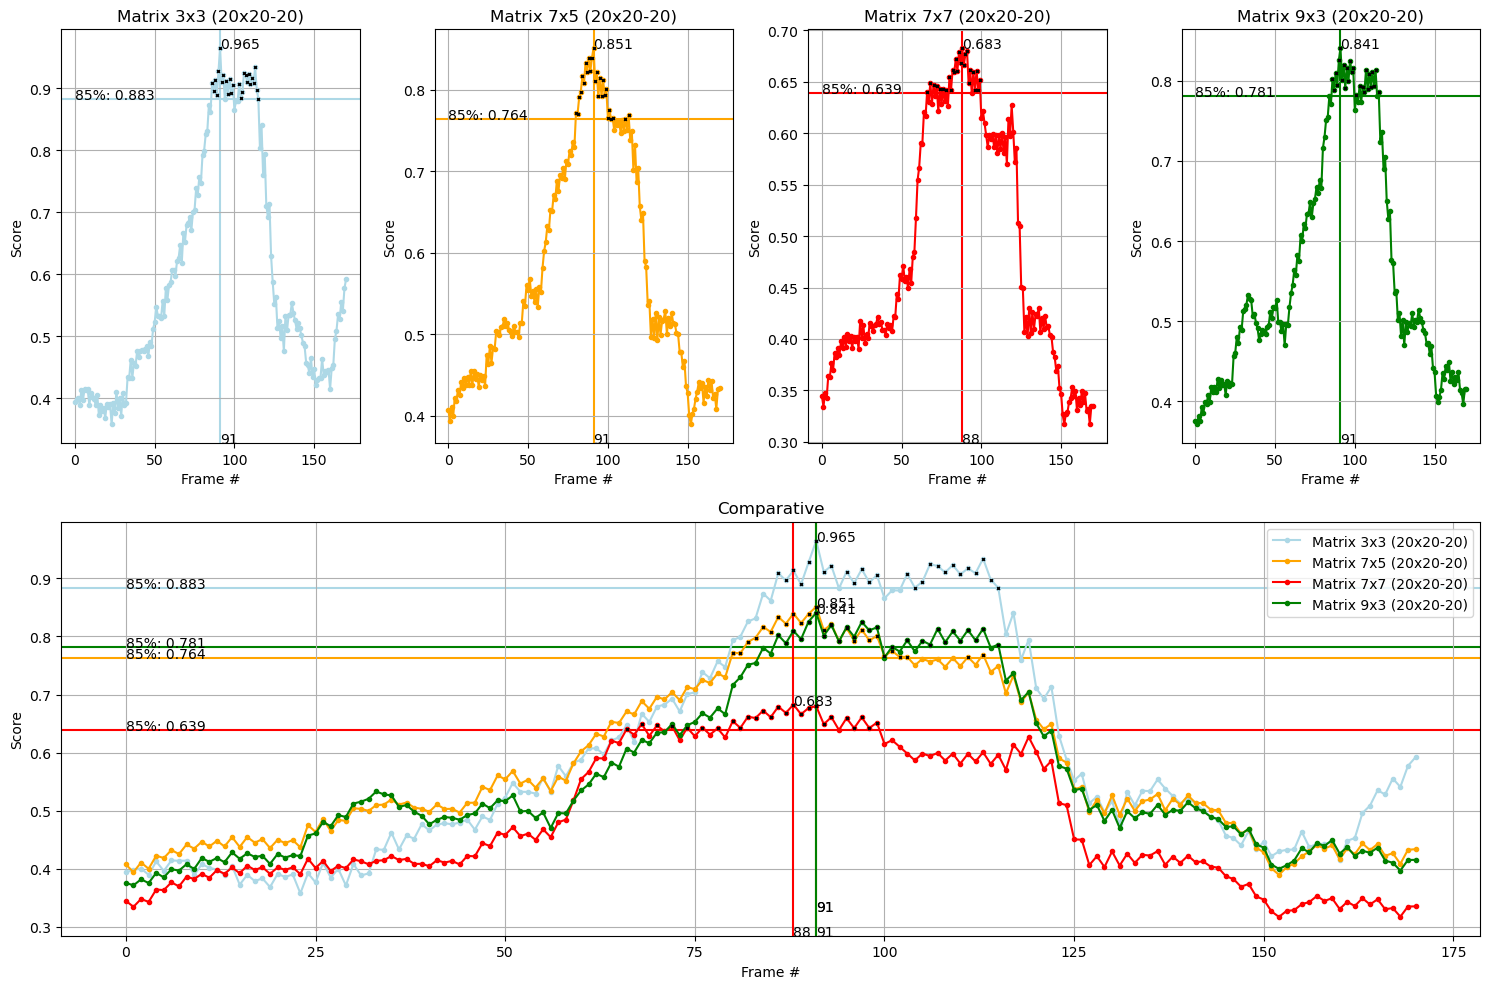

In [15]:
colors = ["lightblue", "orange", "red", "green"]
top_frames += plot_comparative(matrix_frame_iqm, [r"Matrix 3x3 (20x20-20)", r"Matrix 7x5 (20x20-20)", r"Matrix 7x7 (20x20-20)", r"Matrix 9x3 (20x20-20)"], [15,10], colors)

- Con matrices de distintos tamaños (de 20 pixeles x 20 pixeles, espaciadas 20 pixeles), vemos que la matriz que obtiene los mejores valores de foco es la de 3x3, cuyo frame óptimo es el 91 y rango top 85% aprox entre 86 y 115.  
- En la matriz de 7x5 vemos que el rango esta aproximadamente desde el frame 80, hasta el 103(con 2 puntos más cerca del 115). Esto se debe a que evidentemente esta tomando otras áreas para el cálculo.  
- La matriz de 9x3 tiene mejor métrica que la anterior, con un top 85% ligeramente superior, frame óptimo en 91 y rango entre 86 y 115 aprox, con algunos puntos centrales por debajo del top 85% (comportamiento similar a 3x3, aunque con valores menores).  
- La matriz de 7x7 tiene metricas mucho mas bajas, el top frame es el 80, y el rango bastante corrido respecto a las anteriores, que va desde el frame 66 aprox hasta 99, con varios puntos dentro de este rango por debajo del top 85%.

Se ven mejores métricas en las matrices horizontales, y en la mas pequeña, de 3x3.

#### Y algunos mas

In [16]:
matrix_frame_iqm = []
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=1, matrix_m=3, box_width_px=40, box_height_px=20, space_px=30, measure_func=image_quality_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=3, matrix_m=1, box_width_px=20, box_height_px=40, space_px=30, measure_func=image_quality_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=9, box_width_px=10, box_height_px=10, space_px=30, measure_func=image_quality_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=9, box_width_px=30, box_height_px=30, space_px=10, measure_func=image_quality_measure))

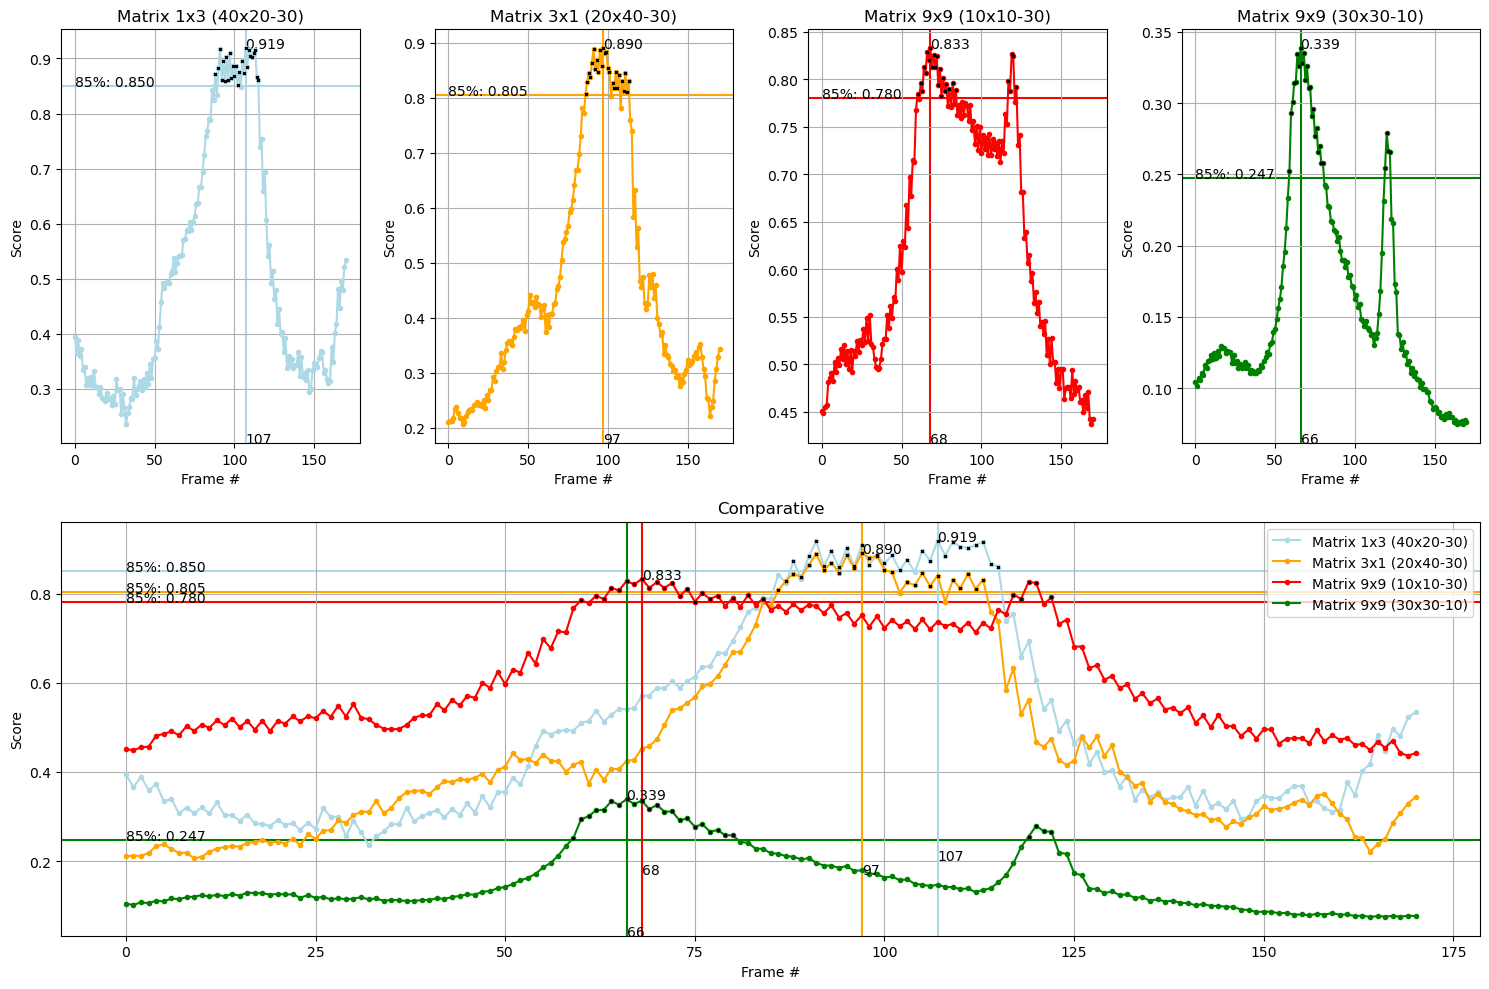

In [17]:
top_frames += plot_comparative(matrix_frame_iqm, [r"Matrix 1x3 (40x20-30)", r"Matrix 3x1 (20x40-30)", r"Matrix 9x9 (10x10-30)", r"Matrix 9x9 (30x30-10)"], [15,10], colors)

- En este caso las matrices de 1x3 (40w x 20h, 1 fila, 3 columnas, rectangulos más anchos que altos) y 3x1 (20w x 40h, 3 filas, 1 columna, rectangulos más altos que anchos) tienen un comportamiento similar, se ve ligeramente mejor la matriz de 1x3 en cuanto a valores y top 85%.  
- La matriz de 9x9 (con cuadrados de 10x10 pixeles espaciados 30 pixeles) tiene mejor foco en el frame 68. El rango top 85% va desde el frame 61 al 84, con algunos puntos por debajo, y otro rango donde detecta buen foco entre el frame 117 y 122.  
- Algo similar ocurre con la otra matriz de 9x9 (con cuadrados de 30x30 pixeles espaciados 10 pixeles), aunque con una métrica muy inferior. Evidentemente estas últimas 2 matrices estan considerando áreas descentradas, donde el foco ocurre en frames distintos a los que veniamos observando.


## 2. Métricas usando Histogram entropy (STA7) y Tenengrad (GRA6)

In [18]:
def sta7_measure(gray_image: np.ndarray) -> float:
    """
    Calculate Histogram entropy (STA7) measure

    Parameters
    ---------
    I (np.ndarray)
        Source image
    
    Returns
    ---------
    FM (float)
        Histogram entropy (STA7) measure for input image
    """
    if (gray_image.ndim != 2): raise Exception("Only 2D (gray) images allowed.")

    hist,_ = np.histogram(gray_image.ravel(),256,(0,256))
    hist = hist / hist.sum()
    res = 0
    for Pk in hist:
        if (Pk != 0):
            res += Pk*np.log(Pk)
    return -res

In [19]:
def sharpness_tenengrad(image_gray, threshold=100):
    # Sobel en x e y
    Gx = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3)
    Gy = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)

    # Magnitud del gradiente
    FM = Gx**2 + Gy**2

    # Umbral
    FM_thresh = FM > threshold
    sharpness = np.sum(FM_thresh) / FM.size

    return sharpness

In [20]:
# Test algorithm 
img_lena = cv2.imread('./img/lena_std.tif', cv2.IMREAD_GRAYSCALE)
print(f"Lena Histogram entropy (STA7): {sta7_measure(img_lena):.4f}")
print(f"Lena Tenengrad (GRA6): {sharpness_tenengrad(img_lena):.4f}")

Lena Histogram entropy (STA7): 5.1605
Lena Tenengrad (GRA6): 0.8021


In [21]:
video_path = "./video/focus_video.mov"
full_frame_iqm = process_video(video_path, full_frame_analysis, measure_func=sta7_measure)
full_frame_iqm2 = process_video(video_path, full_frame_analysis, measure_func=sharpness_tenengrad)

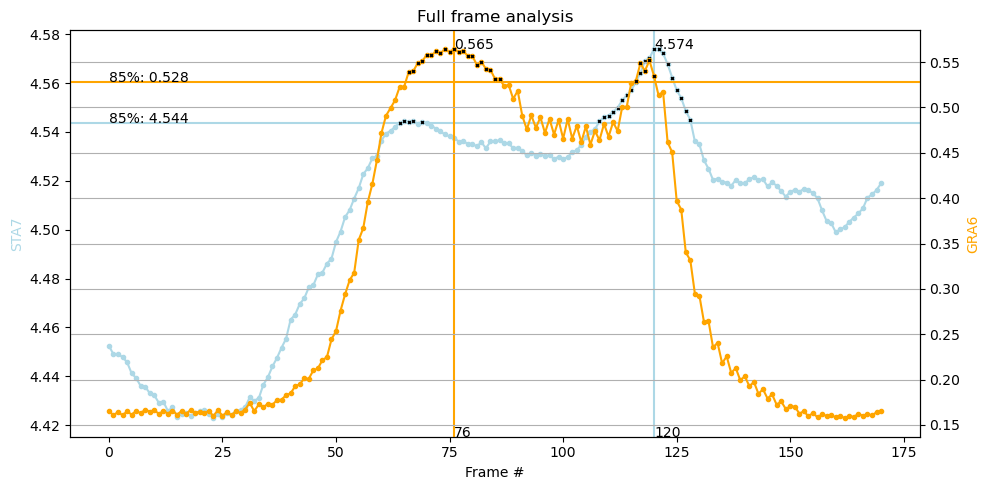

In [22]:
_, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(full_frame_iqm, marker='o', linestyle='-', color="lightblue", zorder=5, markersize=3)
max_frame = int(np.argmax(full_frame_iqm))
ax1.axvline(max_frame, color="lightblue", zorder=1)
ax1.text(max_frame, plt.ylim()[0], str(max_frame))
ax1.text(max_frame, full_frame_iqm[max_frame], f"{full_frame_iqm[max_frame]:.3f}")
perc_x, perc_y, perc_v, _ = percentile_calc(full_frame_iqm, 85)
ax1.plot(perc_x, perc_y, marker='x', linestyle='', color="black", markersize=2, zorder=10)
ax1.axhline(perc_v, color="lightblue", zorder=1)
ax1.text(0, perc_v, f"85%: {perc_v:.3f}")
ax1.set_ylabel("STA7", color="lightblue")
ax1.set_xlabel("Frame #")
top_frames.append((max_frame, "STA7 Full frame analysis"))
ax2 = ax1.twinx()
ax2.plot(full_frame_iqm2, marker='o', linestyle='-', color="orange", zorder=5, markersize=3)
max_frame = int(np.argmax(full_frame_iqm2))
ax2.axvline(max_frame, color="orange", zorder=1)
ax2.text(max_frame, plt.ylim()[0], str(max_frame))
ax2.text(max_frame, full_frame_iqm2[max_frame], f"{full_frame_iqm2[max_frame]:.3f}")
perc_x, perc_y, perc_v, _ = percentile_calc(full_frame_iqm2, 85)
ax2.plot(perc_x, perc_y, marker='x', linestyle='', color="black", markersize=2, zorder=10)
ax2.axhline(perc_v, color="orange", zorder=1)
ax2.text(0, perc_v, f"85%: {perc_v:.3f}")
ax2.set_ylabel("GRA6", color="orange")
ax2.set_xlabel("Frame #")
top_frames.append((max_frame, "GRA6 Full frame analysis"))

plt.title("Full frame analysis")
plt.grid(True)
plt.tight_layout()
plt.show()

Si bien estamos comparando métricas distintas, se pueden comparar el mejor frame y los rangos top 85%.  
- Para el STA7, el top frame es el 120 y el rango esta entre 108 y 128, con otro rango menor entre 63 y 68 aprox.  
- El GRA6 tiene el top frame en 76 y el rango esta entre 66 y 85, con otro rango menor entre 116 y 120.

Claramente estan detectando el mejor foco en puntos distintos, aunque el segundo rango de una se superpone con el primer rango de la otra (podemos considerar la posibilidad de foco en el segundo rango).

In [23]:
def plot_comparative_twin(elements: list[tuple[list[float], list[float]]], label_y_l: str, label_y_r: str, labels: list[str], figsize: list[int], colors: tuple[list[str], list[str]]) -> list[tuple[int, str]]:
    """
    Función auxiliar para graficar varios arrays uno al lado del otro y una comparativa de todos debajo.

    Parameters
    ---------
    elements (list[list[float]])
        Lista de arrays que se graficarán
    labels (list[str])
        Lista de labels para cada array.
    figsize (list[int])
        Tamaño del gráfico completo.
    colors (list[str])
        Colores aplicados a cada array graficado.
    """
    top_frames = []
    plt.figure(figsize=figsize)
    axn=plt.subplot(212)
    axn2=axn.twinx()
    for x in range(len(elements)):
        ax=plt.subplot(200 + len(elements) * 10 + x + 1)
        ax.plot(elements[x][0], marker='o', linestyle='-', color=colors[0][x], zorder=5, markersize=3)
        max_frame = int(np.argmax(elements[x][0]))
        ax.axvline(max_frame, color=colors[0][x], zorder=1)
        ax.text(max_frame, ax.get_ylim()[0], str(max_frame))
        ax.text(max_frame, elements[x][0][max_frame], f"{elements[x][0][max_frame]:.3f}")
        ax.set_xlabel("Frame #")
        ax.set_ylabel(label_y_l, color=colors[0][x])
        ax.set_title(label=labels[x])
        ax.grid(True)
        perc_x1, perc_y1, perc_v1, _ = percentile_calc(elements[x][0], 85)
        ax.plot(perc_x1, perc_y1, marker='x', linestyle='', color="black", markersize=2, zorder=10)
        ax.axhline(perc_v1, color=colors[0][x], zorder=1)
        ax.text(0, perc_v1, f"85%: {perc_v1:.3f}")
        top_frames.append((max_frame, f"{labels[x]}-{label_y_l}"))
        # ---
        ax=ax.twinx()
        ax.plot(elements[x][1], marker='o', linestyle='-', color=colors[1][x], zorder=5, markersize=3)
        max_frame = int(np.argmax(elements[x][1]))
        ax.axvline(max_frame, color=colors[1][x], zorder=1)
        ax.text(max_frame, ax.get_ylim()[0], str(max_frame))
        ax.text(max_frame, elements[x][1][max_frame], f"{elements[x][1][max_frame]:.3f}")
        ax.set_xlabel("Frame #")
        ax.set_ylabel(label_y_r, color=colors[1][x])
        ax.set_title(label=labels[x])
        ax.grid(True)
        perc_x2, perc_y2, perc_v2, _ = percentile_calc(elements[x][1], 85)
        ax.plot(perc_x2, perc_y2, marker='x', linestyle='', color="black", markersize=2, zorder=10)
        ax.axhline(perc_v2, color=colors[1][x], zorder=1)
        ax.text(150, perc_v2, f"85%: {perc_v2:.3f}")
        top_frames.append((max_frame, f"{labels[x]}-{label_y_r}"))

        axn.plot(elements[x][0], marker='o', linestyle='-', color=colors[0][x], label=f"{labels[x]}-{label_y_l}", markersize=3)
        axn.axvline(max_frame, color=colors[0][x])
        axn.text(max_frame, axn.get_ylim()[0], str(max_frame))
        axn.text(max_frame, elements[x][0][max_frame], f"{elements[x][0][max_frame]:.3f}")
        axn.plot(perc_x1, perc_y1, marker='x', linestyle='', color="black", markersize=2, zorder=10)
        axn.axhline(perc_v1, color=colors[0][x], zorder=1)
        axn.text(0, perc_v1, f"85%: {perc_v1:.3f}")
        # ------
        axn2.plot(elements[x][1], marker='o', linestyle='-', color=colors[1][x], label=f"{labels[x]}-{label_y_r}", markersize=3)
        axn2.axvline(max_frame, color=colors[1][x])
        axn2.text(max_frame, axn2.get_ylim()[0], str(max_frame))
        axn2.text(max_frame, elements[x][1][max_frame], f"{elements[x][1][max_frame]:.3f}")
        axn2.plot(perc_x2, perc_y2, marker='x', linestyle='', color="black", markersize=2, zorder=10)
        axn2.axhline(perc_v2, color=colors[1][x], zorder=1)
        axn2.text(150, perc_v2, f"85%: {perc_v2:.3f}")

    axn.set_xlabel("Frame #")
    axn.set_ylabel(label_y_l)
    axn2.set_ylabel(label_y_r)
    axn2.set_xlabel("Frame #")
    axn.set_title(r"Comparative")
    lines, labels = axn.get_legend_handles_labels()
    lines2, labels2 = axn2.get_legend_handles_labels()
    axn2.legend(lines + lines2, labels + labels2, loc="lower right")

    plt.tight_layout()
    axn.grid(True)
    return top_frames

In [24]:
roi_frame_iqm = []
video_path = "./video/focus_video.mov"
roi_frame_iqm.append((process_video(video_path, roi_frame_analysis, roi=0.1, measure_func=sta7_measure), 
                      process_video(video_path, roi_frame_analysis, roi=0.1, measure_func=sharpness_tenengrad)))
roi_frame_iqm.append((process_video(video_path, roi_frame_analysis, roi=0.05, measure_func=sta7_measure), 
                      process_video(video_path, roi_frame_analysis, roi=0.05, measure_func=sharpness_tenengrad)))

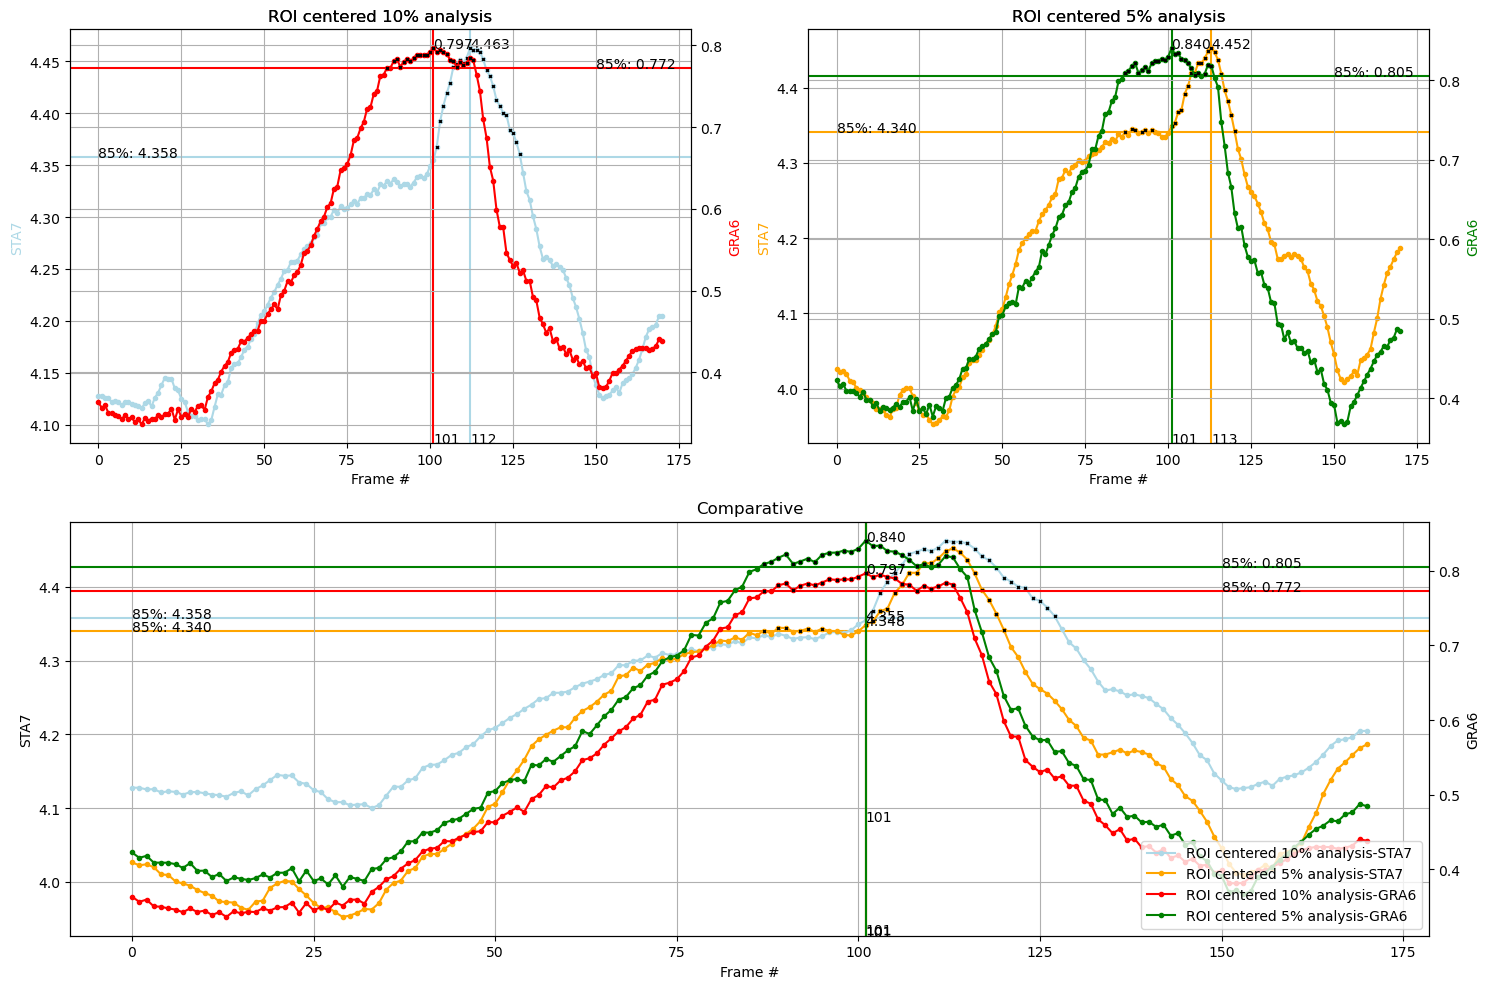

In [25]:
colors = (["lightblue", "orange"],["red", "green"])
top_frames += plot_comparative_twin(roi_frame_iqm, "STA7", "GRA6", [r"ROI centered 10% analysis", r"ROI centered 5% analysis"], [15,10], colors)

Observaciones:
- GRA6 parece tener un rango mas estable de foco.  
- STA7 encuentra foco en un rango menor, formando una especie de pico.  

GRA6 tiene mejor métrica analizando el ROI de 5%, mientras que STA7 tiene mejor métrica analizando el ROI de 10%.

In [26]:
matrix_frame_iqm = []
# Debe dar el resultado del punto 2 para roi 0.1
matrix_frame_iqm.append((process_video(video_path, matrix_frame_analysis, matrix_n=1, matrix_m=1, box_width_px=151, 
                                      box_height_px=151, space_px=20, measure_func=sta7_measure),
                        process_video(video_path, matrix_frame_analysis, matrix_n=1, matrix_m=1, box_width_px=151, 
                                      box_height_px=151, space_px=20, measure_func=sharpness_tenengrad)))
# Debe dar el resultado del punto 2 para roi 0.05
matrix_frame_iqm.append((process_video(video_path, matrix_frame_analysis, matrix_n=1, matrix_m=1, box_width_px=107, 
                                      box_height_px=107, space_px=20, measure_func=sta7_measure),
                        process_video(video_path, matrix_frame_analysis, matrix_n=1, matrix_m=1, box_width_px=107, 
                                      box_height_px=107, space_px=20, measure_func=sharpness_tenengrad))) 
# El gráfico obtenido debería ser igual al punto anterior para los casos 10% y 5%. Hecho solo para verificación.

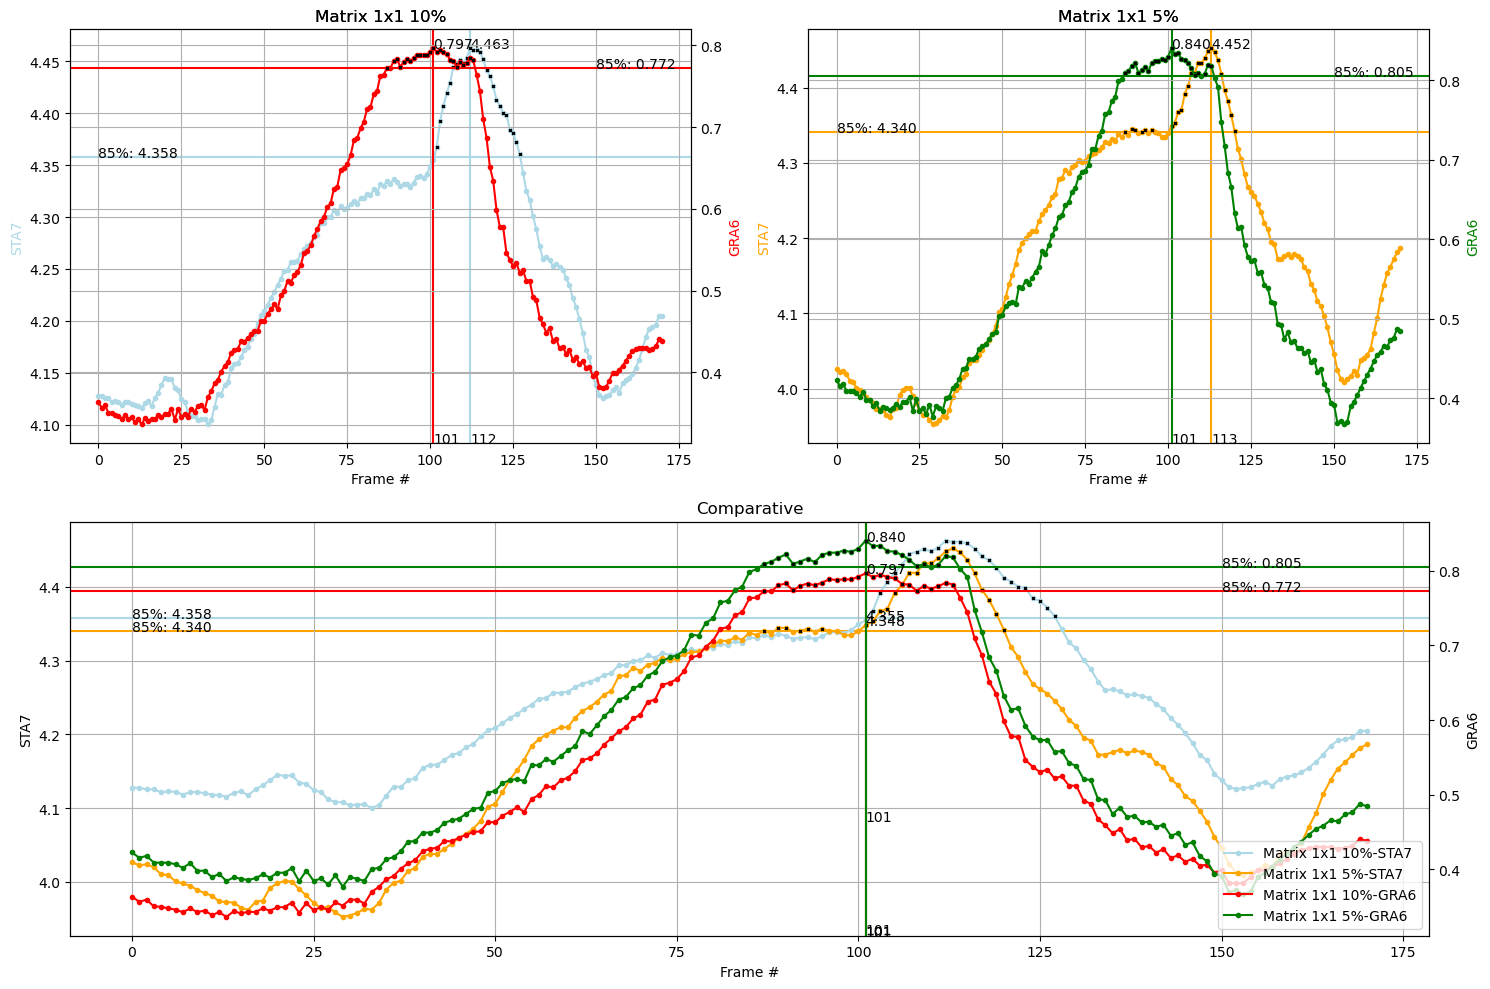

In [27]:
top_frames += plot_comparative_twin(matrix_frame_iqm, "STA7", "GRA6", [r"Matrix 1x1 10%", r"Matrix 1x1 5%"], [15,10], colors)

In [28]:
matrix_frame_iqm = []
matrix_frame_iqm.append((process_video(video_path, matrix_frame_analysis, matrix_n=3, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=sta7_measure),
                         process_video(video_path, matrix_frame_analysis, matrix_n=3, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=sharpness_tenengrad)))
matrix_frame_iqm.append((process_video(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=7, box_width_px=20, box_height_px=20, space_px=20, measure_func=sta7_measure),
                         process_video(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=7, box_width_px=20, box_height_px=20, space_px=20, measure_func=sharpness_tenengrad)))


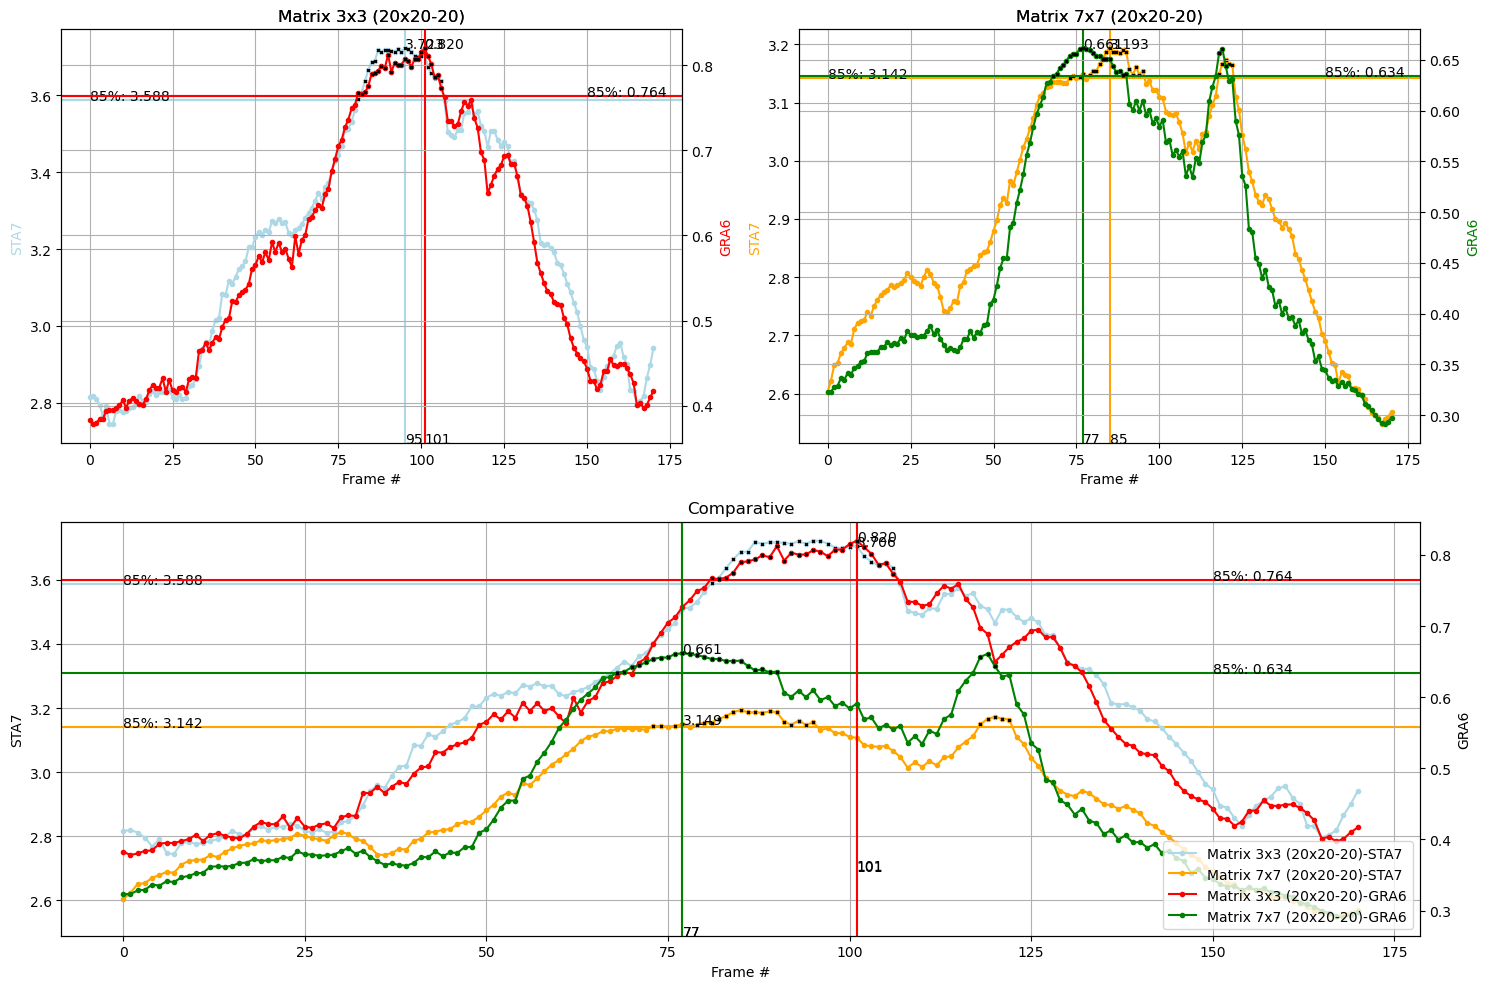

In [29]:
top_frames += plot_comparative_twin(matrix_frame_iqm, "STA7", "GRA6", [r"Matrix 3x3 (20x20-20)", r"Matrix 7x7 (20x20-20)"], [15,10], colors)

- Se puede observar que en la matriz de 9x9 con STA7 y GRA6 tienen un comportamiento similar en general. A diferencia de la matriz 7x7 que en el caso de STA7 tiene el mayor foco en el frame 85 y GRA6 en el frame 77. 

In [30]:
matrix_frame_iqm = []
matrix_frame_iqm.append((process_video(video_path, matrix_frame_analysis, matrix_n=3, matrix_m=1, box_width_px=20, box_height_px=40, space_px=30, measure_func=sta7_measure),
                         process_video(video_path, matrix_frame_analysis, matrix_n=3, matrix_m=1, box_width_px=20, box_height_px=40, space_px=30, measure_func=sharpness_tenengrad)))
matrix_frame_iqm.append((process_video(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=9, box_width_px=10, box_height_px=10, space_px=30, measure_func=sta7_measure),
                         process_video(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=9, box_width_px=10, box_height_px=10, space_px=30, measure_func=sharpness_tenengrad)))

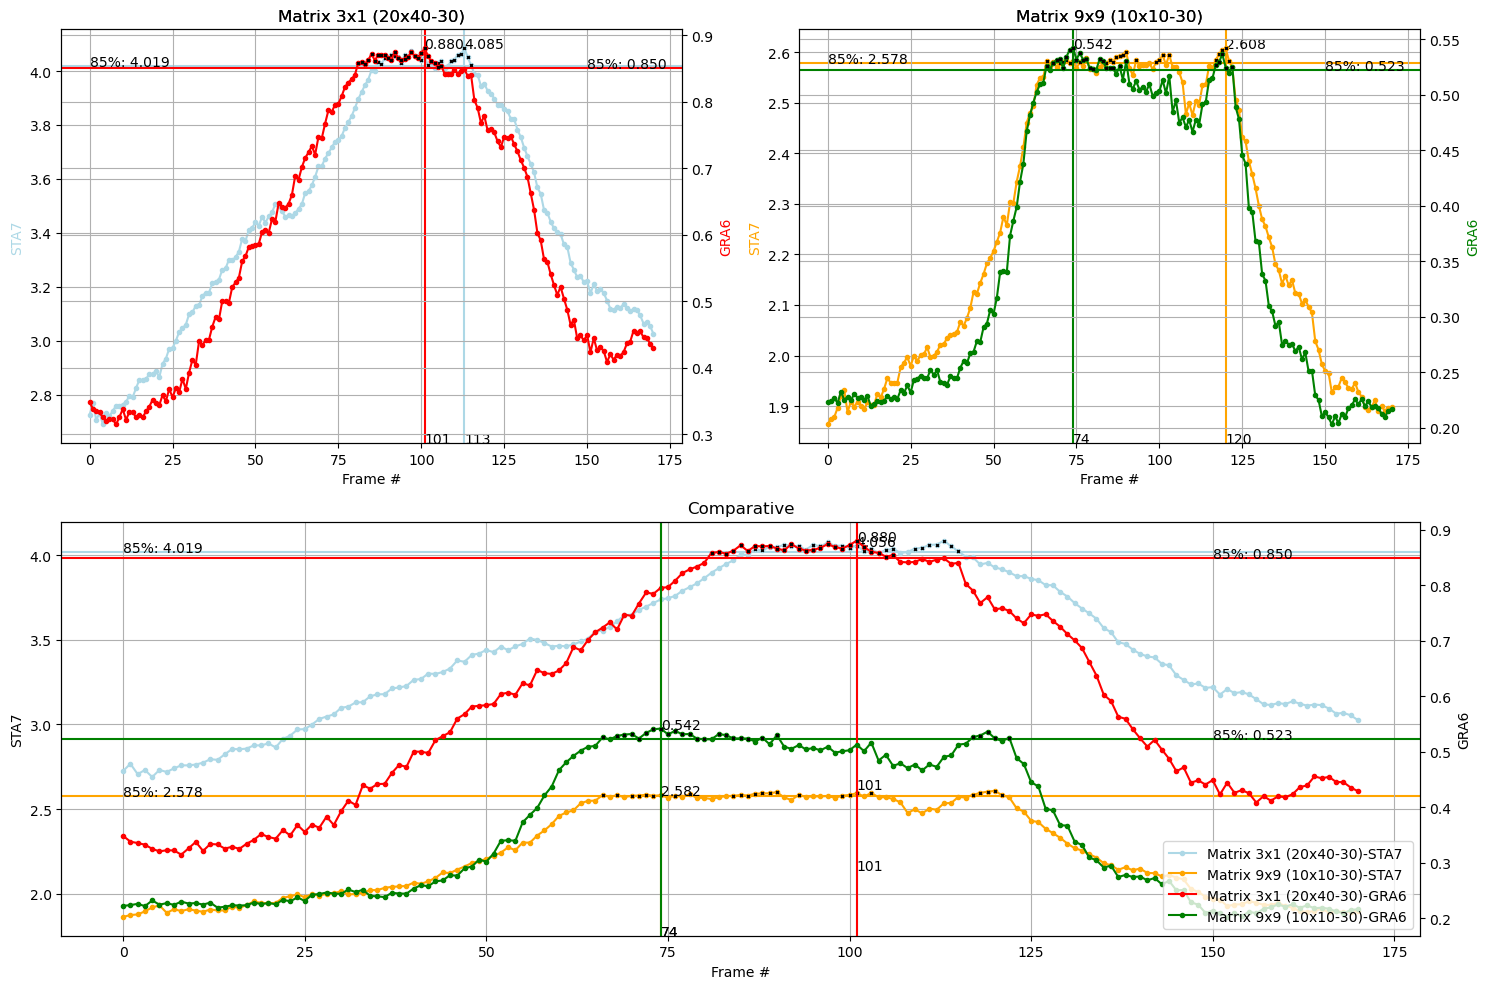

In [31]:
top_frames += plot_comparative_twin(matrix_frame_iqm, "STA7", "GRA6", [r"Matrix 3x1 (20x40-30)", r"Matrix 9x9 (10x10-30)"], [15,10], colors)

- Se puede observar que en la matriz 3x1 en el caso de STA7 tiene el mayor foco en el frame 113 y GRA6 en el frame 101. 
- En la matriz 9x9 en el caso de STA7 tiene el mayor foco en el frame 120 y GRA6 en el frame 74. 

Vemos los top frames hasta el momento

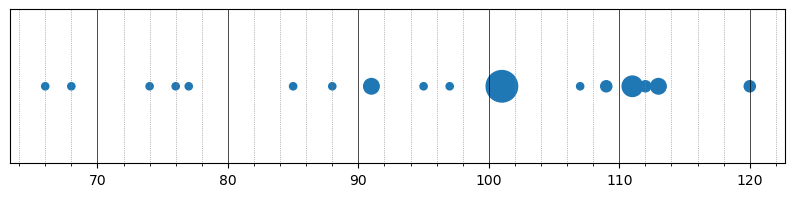

Top frames: 
 Frame                         Prueba
    66          Matrix 9x9 (30x30-10)
    68          Matrix 9x9 (10x10-30)
    74     Matrix 9x9 (10x10-30)-GRA6
    76       GRA6 Full frame analysis
    77     Matrix 7x7 (20x20-20)-GRA6
    85     Matrix 7x7 (20x20-20)-STA7
    88          Matrix 7x7 (20x20-20)
    91          Matrix 3x3 (20x20-20)
    91          Matrix 7x5 (20x20-20)
    91          Matrix 9x3 (20x20-20)
    95     Matrix 3x3 (20x20-20)-STA7
    97          Matrix 3x1 (20x40-30)
   101 ROI centered 10% analysis-GRA6
   101     Matrix 3x1 (20x40-30)-GRA6
   101     Matrix 3x3 (20x20-20)-GRA6
   101             Matrix 1x1 5%-GRA6
   101            Matrix 1x1 10%-GRA6
   101  ROI centered 5% analysis-GRA6
   107          Matrix 1x3 (40x20-30)
   109            Full frame analysis
   109     ROI centered 100% analysis
   111      ROI centered 10% analysis
   111       ROI centered 5% analysis
   111                  Matrix 1x1 5%
   111                 Matrix 1x1 10%

In [32]:
import pandas as pd
df = pd.DataFrame(top_frames, columns=["Frame", "Prueba"])
unique_top_frames = df["Frame"].sort_values().unique()
fig, ax = plt.subplots(figsize=(10,2))
ax.scatter(unique_top_frames, np.zeros_like(unique_top_frames), s=(df["Frame"].value_counts().sort_index()+2)**3)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax.yaxis.set_visible(False)
plt.show()
print("Top frames: \n" + df.sort_values("Frame").to_string(index=False))


Conclusion preliminar:

- Según el gráfico anterior, podríamos pensar que el foco esta entre los frame 101, ya que 6 de las pruebas coincidieron en ese frame.  
- El frame que le sigue en cantidad de coincidencias es el 111, con 4 pruebas. Le siguen los frames 91, 109 y 113 con 3 coincidencias y 112 con 2 coincidencias.

## 3. Unsharp masking para expandir la zona de enfoque y recalcular la métrica

In [33]:
def unsharp_masking(img: np.ndarray) -> np.ndarray:
    # desenfoque con filtro gaussiano
    img_blurred = cv2.GaussianBlur(img, (7,7), 0.5)
    k = 1 # k = 1 unsharp masking; k > 1 highboost filtering
    img_unsharped = cv2.addWeighted(img, k + 1, img_blurred, -k, 0)
    return img_unsharped

In [34]:
def process_video_enhance(video_path: str, frame_func, **kwargs) -> list[float]:
    """
    Abre y recorre un video frame por frame, invocando a la funcion frame_func por cada frame.
    Realiza una segunda pasada por los frames con percentil por encima de 40 y debajo de 85 aplicando unsharp_masking.
    Guarda el resultado de frame_func en un array que es retornado como resultado

    Parameters
    ---------
    video_path (str)
        Ruta al video
    frame_func (Callable[[np.ndarray], float])
        Función que se invoca por cada frame.
        Debe aceptar la imagen del frame como np.ndarray.
        Debe retornar el valor del procesamiento del frame como float.
    
    Returns
    ---------
    (tuple[list[float], list[int]])
        _ Array de resultados obtenidos por el procesamiento de cada frame
        _ Valor del percentil 90

    """
    video = cv2.VideoCapture(video_path)
    if not video.isOpened(): raise Exception("Error al abrir el archivo de video")

    try:
        res_array = []
        while True:
            ret, frame = video.read()
            if not ret: break
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            single_frame_res = frame_func(frame_gris, **kwargs)
            res_array.append(single_frame_res)
        
        perc_x, _, _, _ = percentile_calc(res_array, 60, 85)
        for n in perc_x:
            video.set(cv2.CAP_PROP_POS_FRAMES, n)
            ret, frame = video.read()
            if not ret: break
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_gris = unsharp_masking(frame_gris)
            single_frame_res = frame_func(frame_gris, **kwargs)
            res_array[n] = single_frame_res
            
        return res_array
    finally:
        video.release()

[(88, 'GRA6 - Unsharpened - ROI centered 10% analysis'),
 (101, 'GRA6 - Normal - ROI centered 10% analysis')]

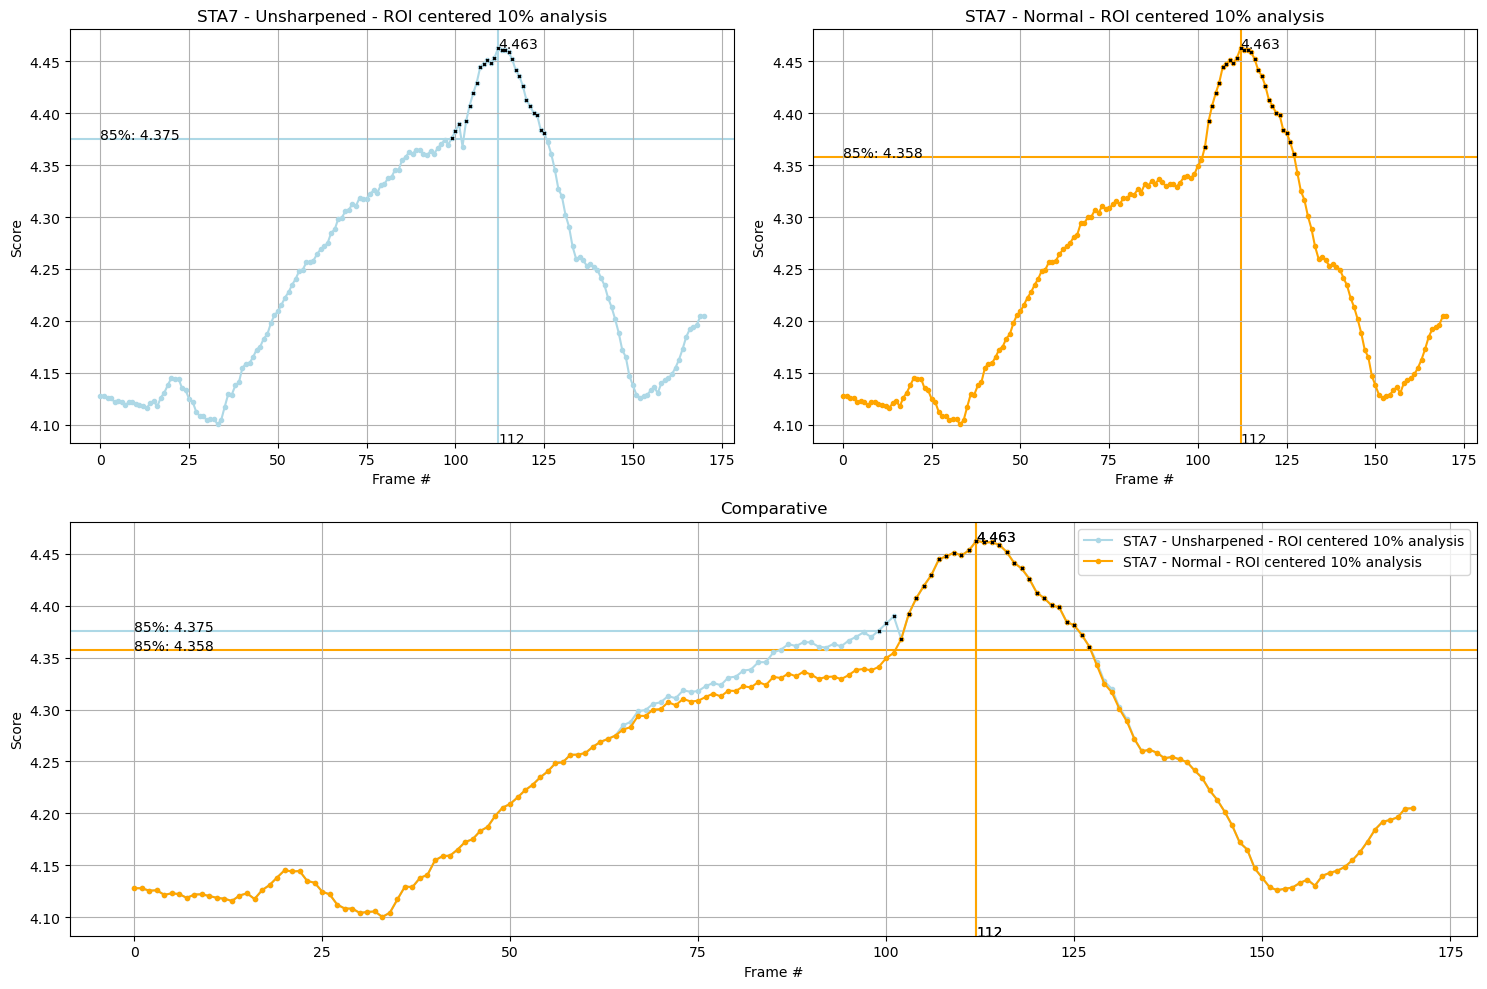

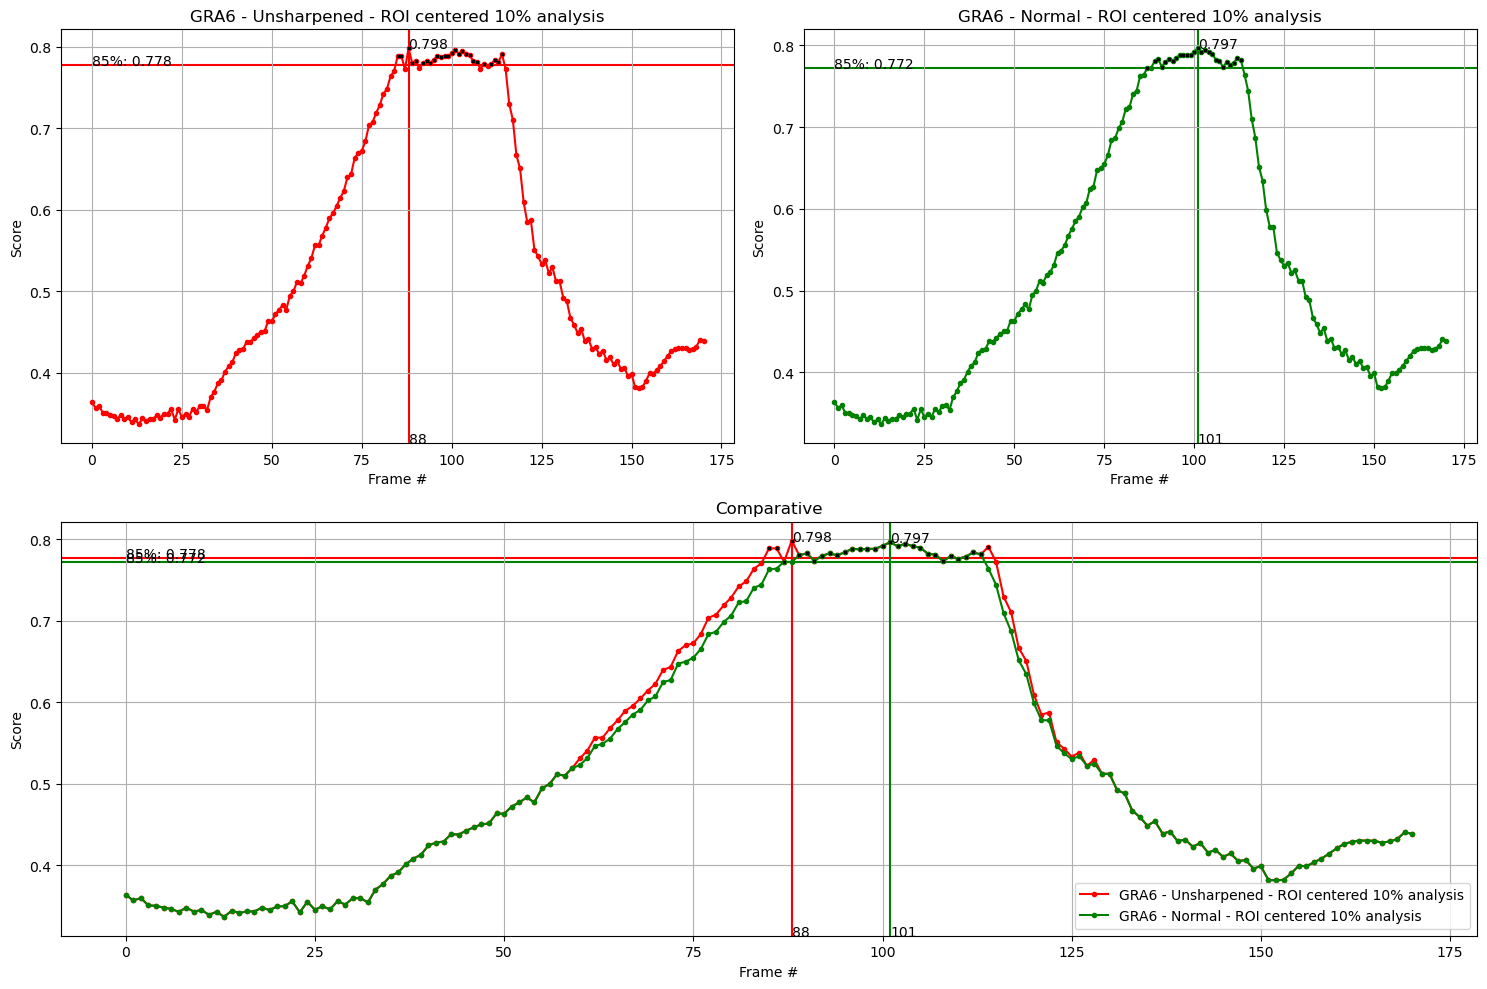

In [35]:
video_path = "./video/focus_video.mov"
roi_frame_iqm_sta7 = [process_video_enhance(video_path, roi_frame_analysis, roi=0.1, measure_func=sta7_measure),
                      process_video(video_path, roi_frame_analysis, roi=0.1, measure_func=sta7_measure)]
roi_frame_iqm_gra6 = [process_video_enhance(video_path, roi_frame_analysis, roi=0.1, measure_func=sharpness_tenengrad),
                      process_video(video_path, roi_frame_analysis, roi=0.1, measure_func=sharpness_tenengrad)]
colors = ["lightblue", "orange", "red", "green"]
plot_comparative(roi_frame_iqm_sta7, [r"STA7 - Unsharpened - ROI centered 10% analysis", r"STA7 - Normal - ROI centered 10% analysis"], [15,10], colors)
plot_comparative(roi_frame_iqm_gra6, [r"GRA6 - Unsharpened - ROI centered 10% analysis", r"GRA6 - Normal - ROI centered 10% analysis"], [15,10], colors[2:])

[(101, 'GRA6 - Unsharpened - ROI centered 5% analysis'),
 (101, 'GRA6 - Normal - ROI centered 5% analysis')]

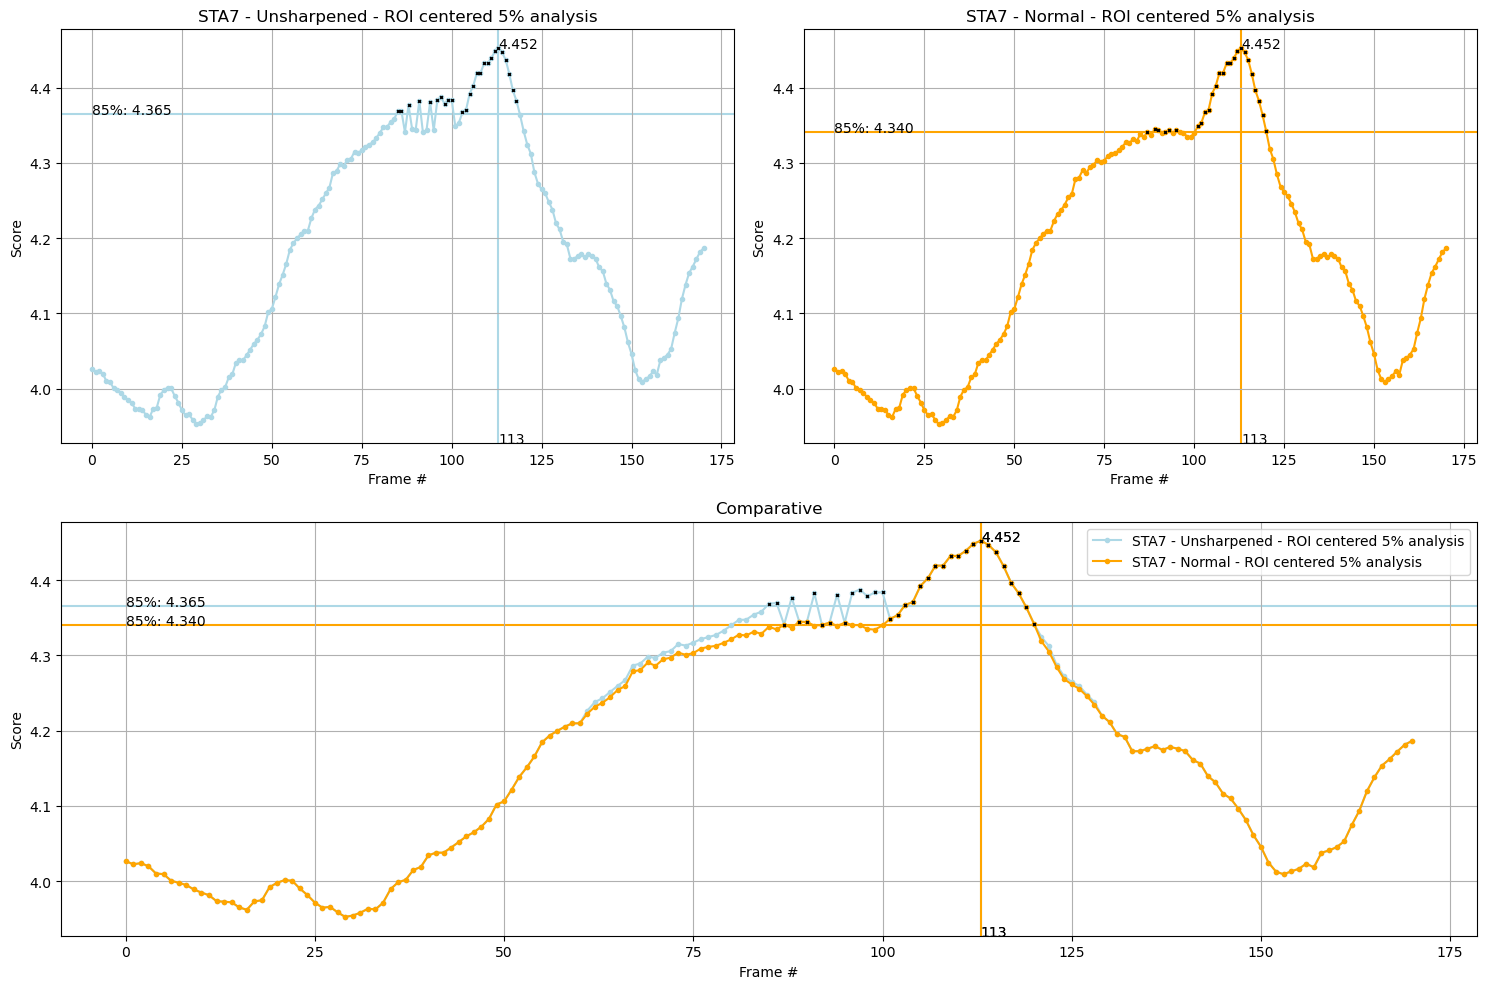

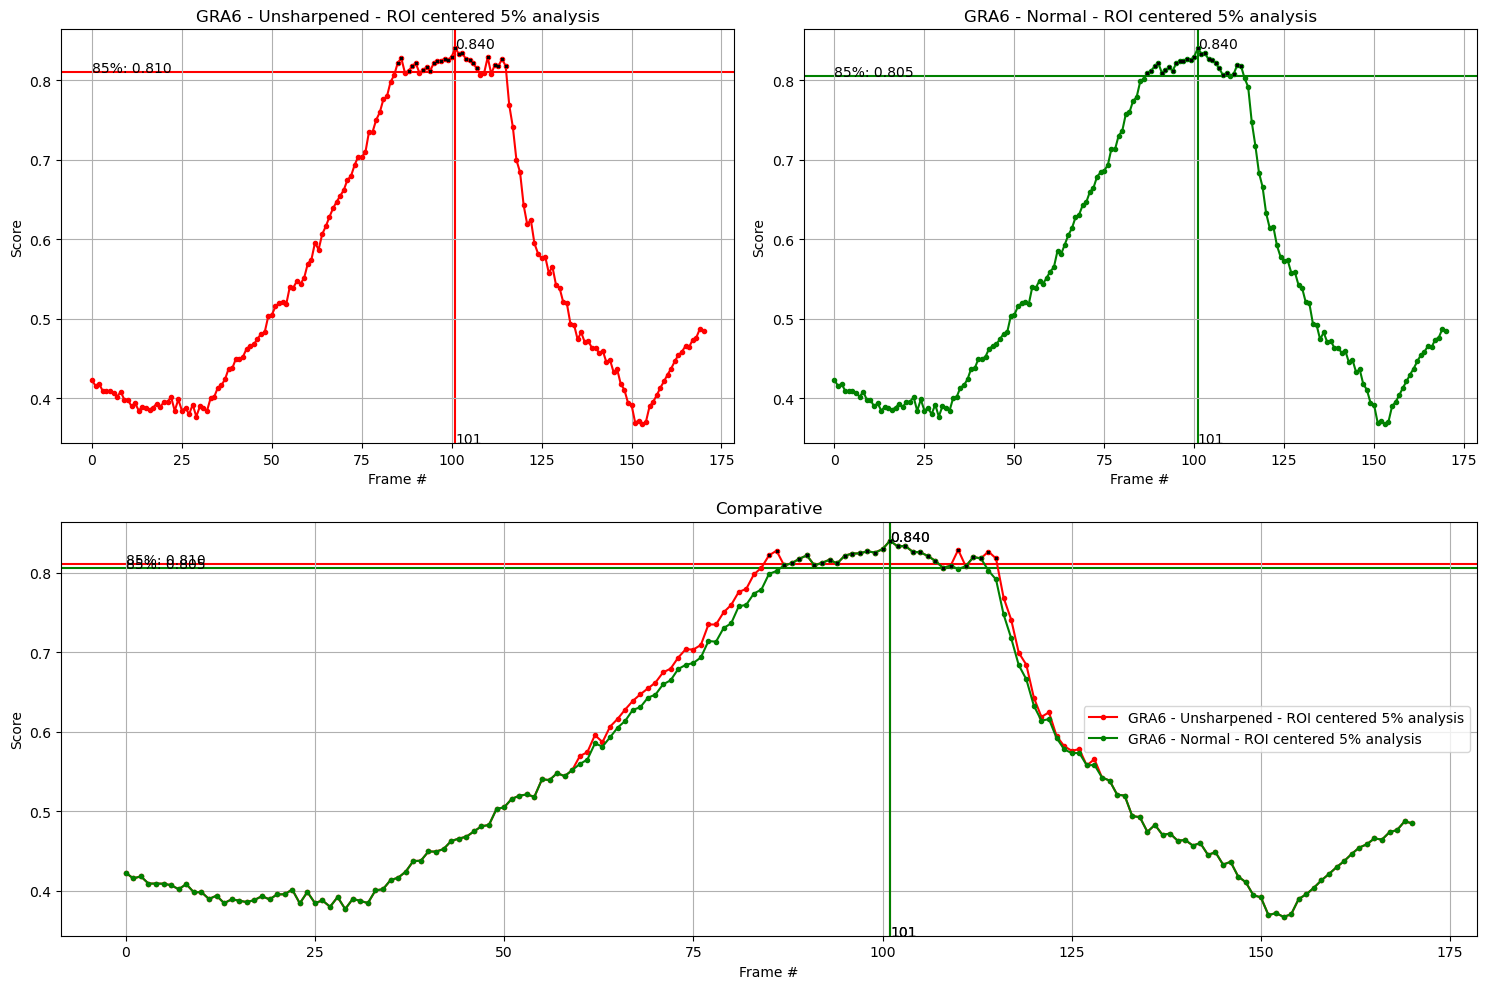

In [36]:
roi_frame_iqm_sta7 = [process_video_enhance(video_path, roi_frame_analysis, roi=0.05, measure_func=sta7_measure),
                      process_video(video_path, roi_frame_analysis, roi=0.05, measure_func=sta7_measure)]
roi_frame_iqm_gra6 = [process_video_enhance(video_path, roi_frame_analysis, roi=0.05, measure_func=sharpness_tenengrad),
                      process_video(video_path, roi_frame_analysis, roi=0.05, measure_func=sharpness_tenengrad)]

plot_comparative(roi_frame_iqm_sta7, [r"STA7 - Unsharpened - ROI centered 5% analysis", r"STA7 - Normal - ROI centered 5% analysis"], [15,10], colors)
plot_comparative(roi_frame_iqm_gra6, [r"GRA6 - Unsharpened - ROI centered 5% analysis", r"GRA6 - Normal - ROI centered 5% analysis"], [15,10], colors[2:])

[(115, 'GRA6 - Unsharpened - ROI centered 100% analysis'),
 (76, 'GRA6 - Normal - ROI centered 100% analysis')]

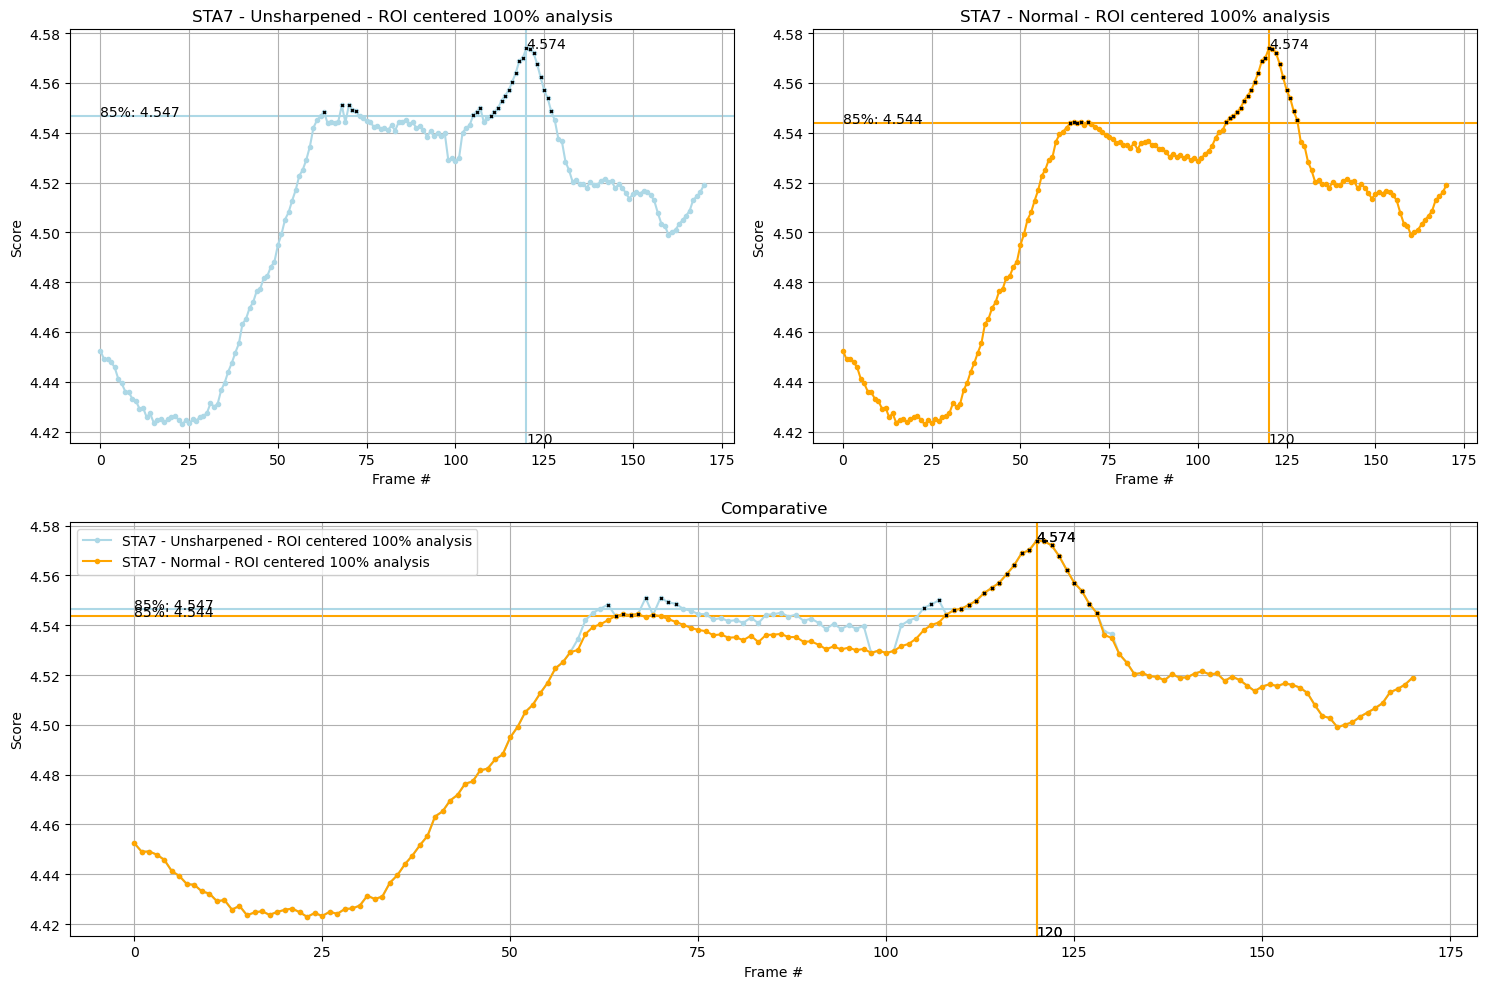

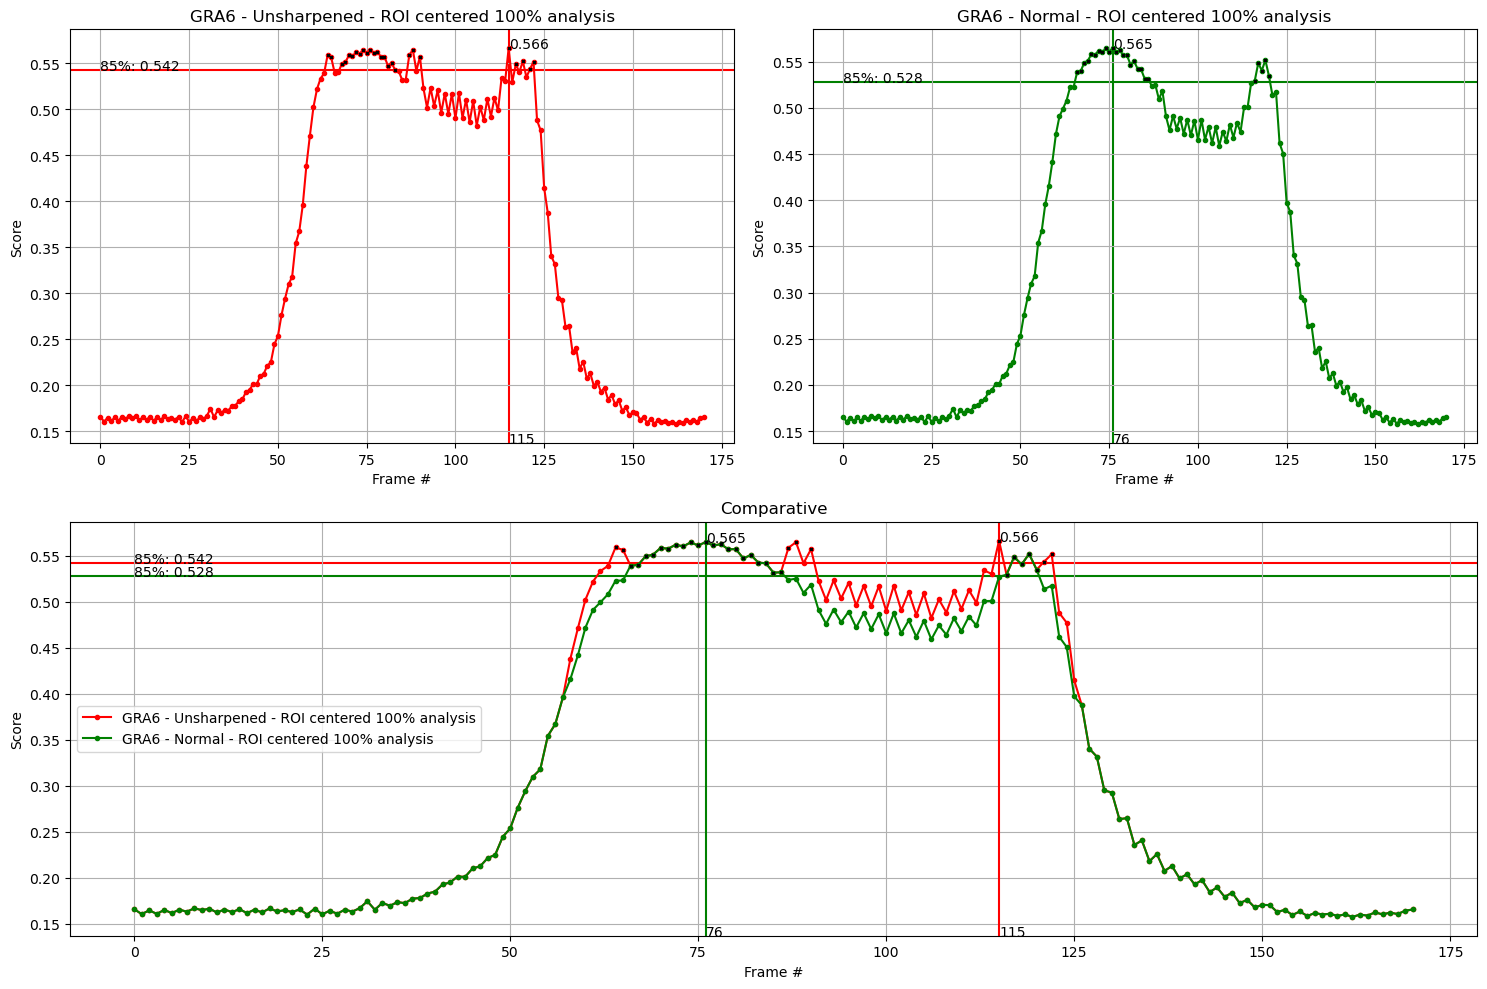

In [37]:
roi_frame_iqm_sta7 = [process_video_enhance(video_path, roi_frame_analysis, roi=1, measure_func=sta7_measure),
                      process_video(video_path, roi_frame_analysis, roi=1, measure_func=sta7_measure)]
roi_frame_iqm_gra6 = [process_video_enhance(video_path, roi_frame_analysis, roi=1, measure_func=sharpness_tenengrad),
                      process_video(video_path, roi_frame_analysis, roi=1, measure_func=sharpness_tenengrad)]

plot_comparative(roi_frame_iqm_sta7, [r"STA7 - Unsharpened - ROI centered 100% analysis", r"STA7 - Normal - ROI centered 100% analysis"], [15,10], colors)
plot_comparative(roi_frame_iqm_gra6, [r"GRA6 - Unsharpened - ROI centered 100% analysis", r"GRA6 - Normal - ROI centered 100% analysis"], [15,10], colors[2:])

[(101, 'GRA6 - Unsharpened - Matrix 3x3 (20x20-20)'),
 (101, 'GRA6 - Normal - Matrix 3x3 (20x20-20)')]

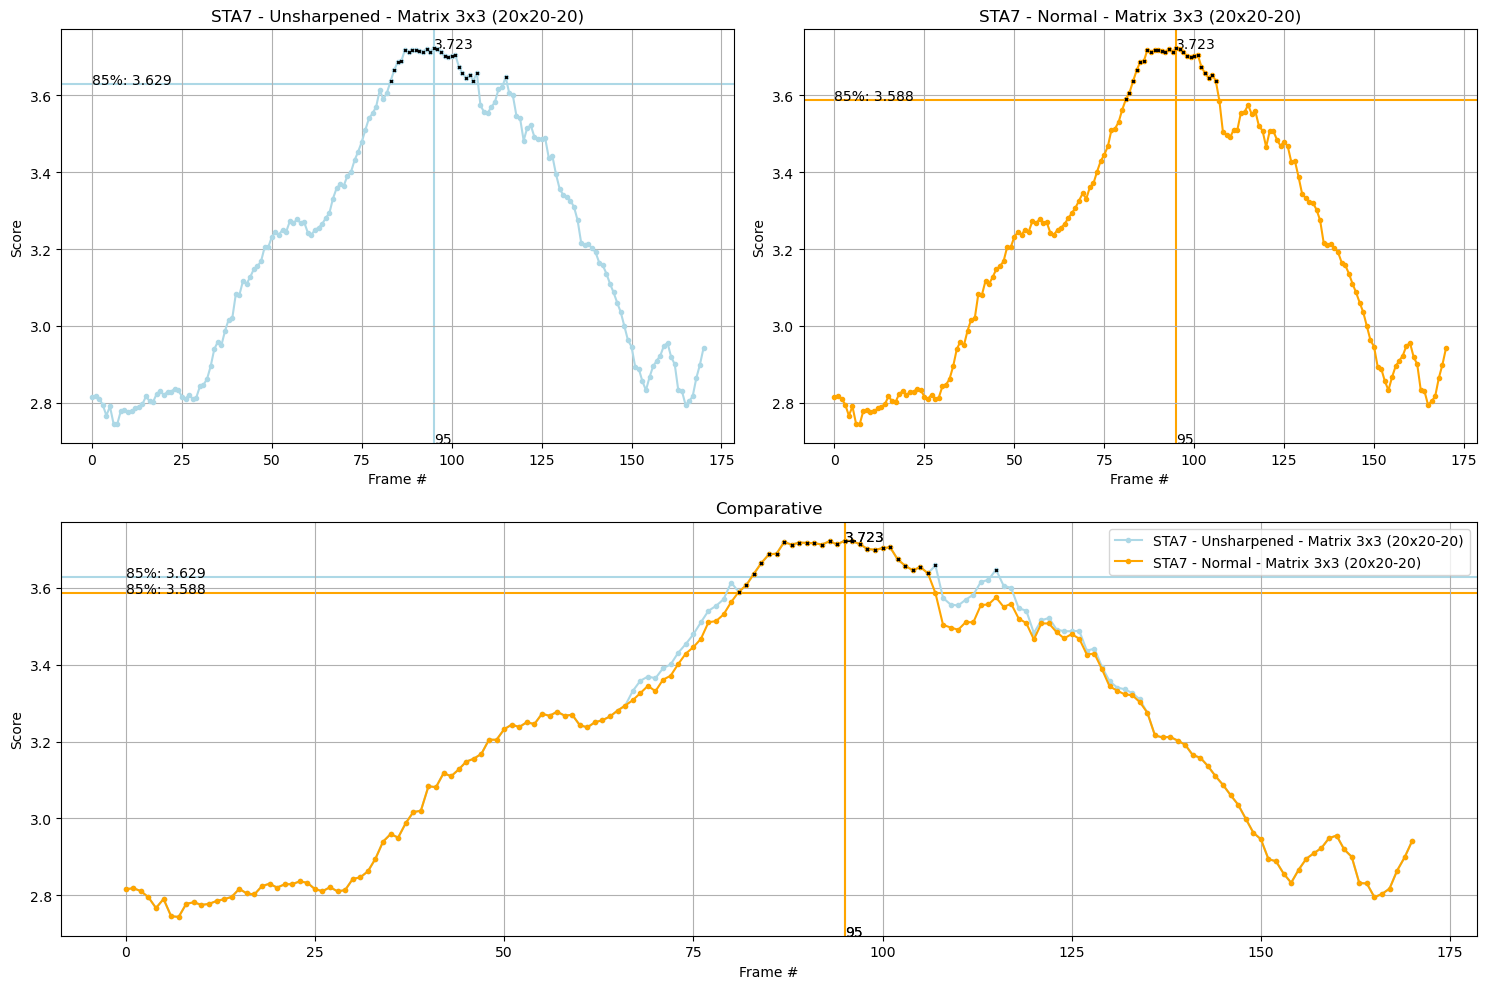

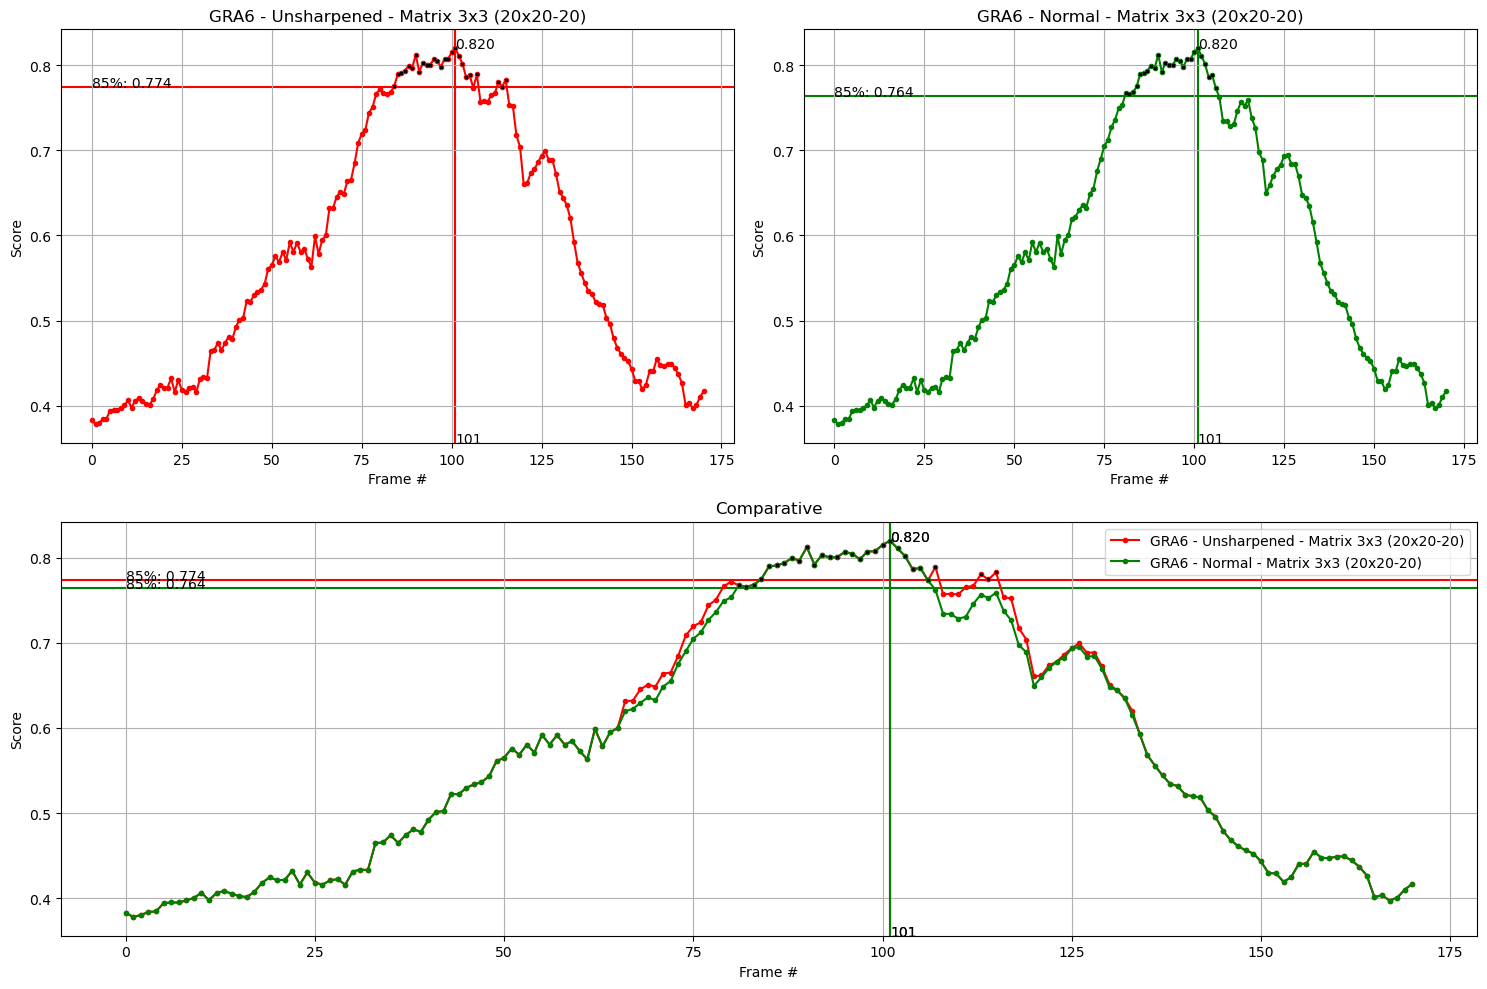

In [38]:
roi_frame_iqm_sta7 = [process_video_enhance(video_path, matrix_frame_analysis, matrix_n=3, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=sta7_measure),
                      process_video(video_path, matrix_frame_analysis, matrix_n=3, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=sta7_measure)]
roi_frame_iqm_gra6 = [process_video_enhance(video_path, matrix_frame_analysis, matrix_n=3, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=sharpness_tenengrad),
                      process_video(video_path, matrix_frame_analysis, matrix_n=3, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=sharpness_tenengrad)]

plot_comparative(roi_frame_iqm_sta7, [r"STA7 - Unsharpened - Matrix 3x3 (20x20-20)", r"STA7 - Normal - Matrix 3x3 (20x20-20)"], [15,10], colors)
plot_comparative(roi_frame_iqm_gra6, [r"GRA6 - Unsharpened - Matrix 3x3 (20x20-20)", r"GRA6 - Normal - Matrix 3x3 (20x20-20)"], [15,10], colors[2:])

[(90, 'GRA6 - Unsharpened - Matrix 7x5 (20x20-20)'),
 (90, 'GRA6 - Normal - Matrix 7x5 (20x20-20)')]

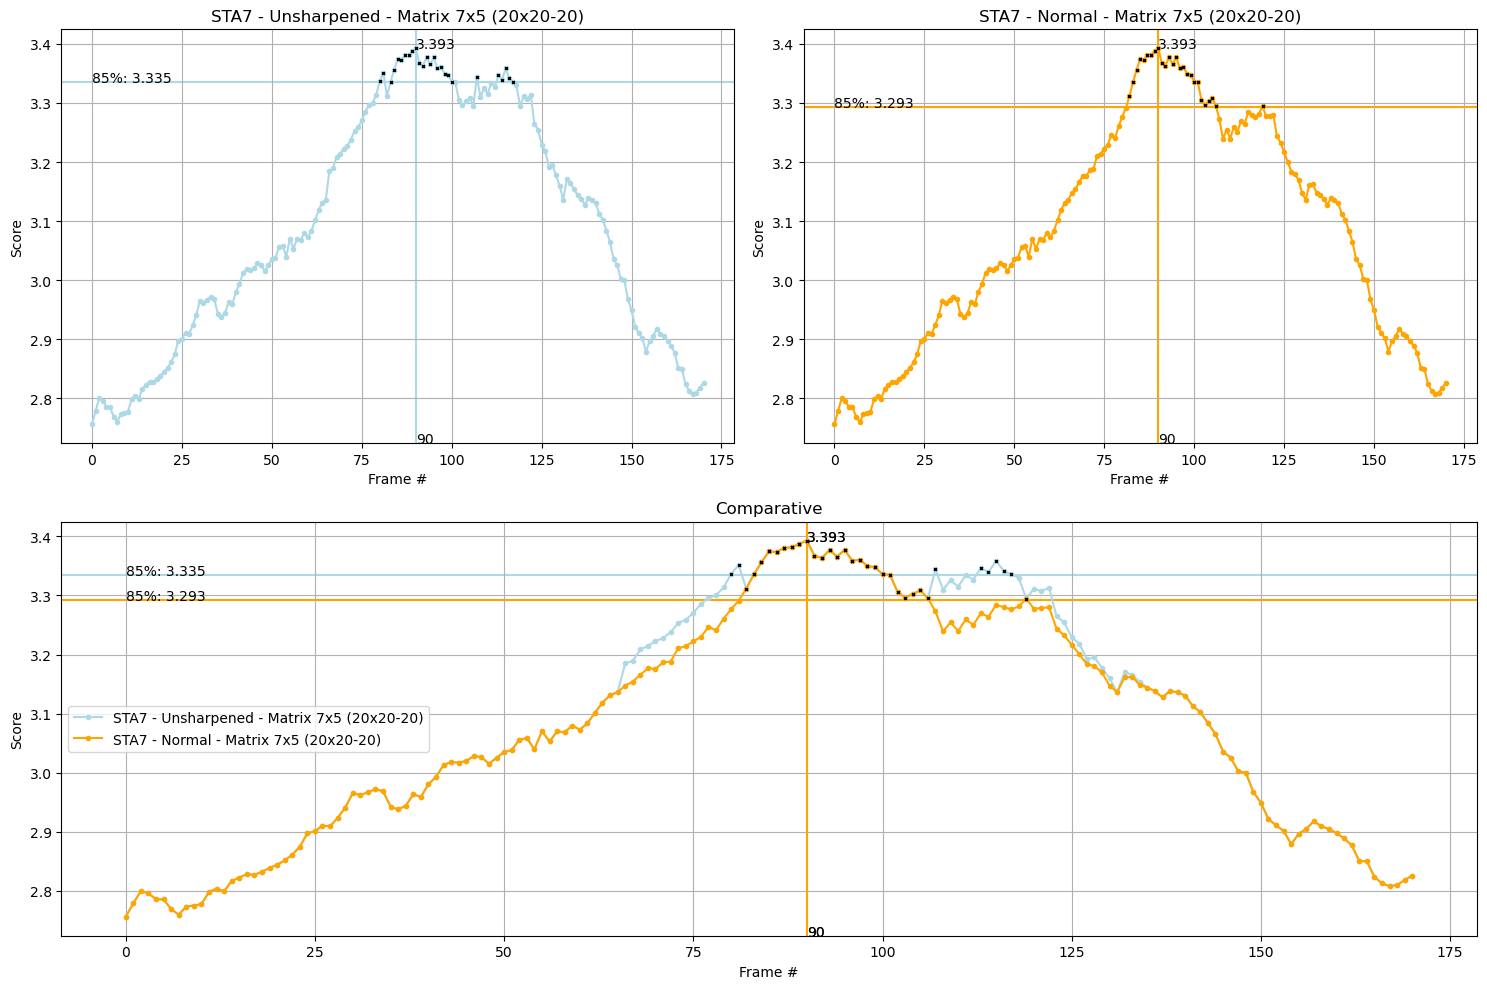

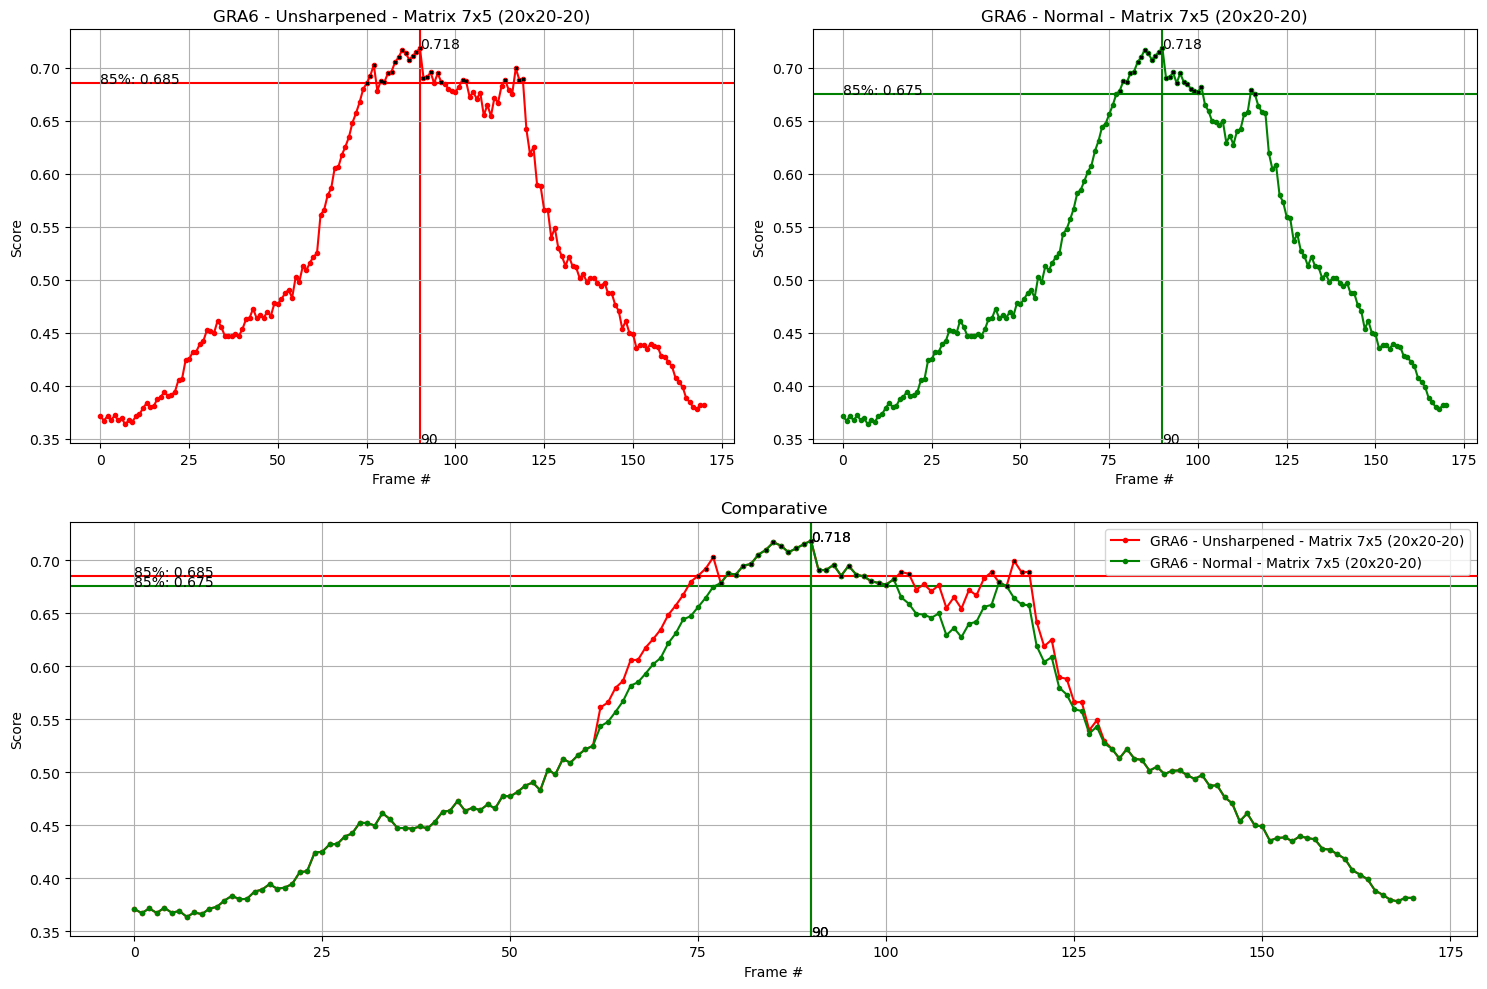

In [39]:
roi_frame_iqm_sta7 = [process_video_enhance(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=5, box_width_px=20, box_height_px=20, space_px=20, measure_func=sta7_measure),
                      process_video(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=5, box_width_px=20, box_height_px=20, space_px=20, measure_func=sta7_measure)]
roi_frame_iqm_gra6 = [process_video_enhance(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=5, box_width_px=20, box_height_px=20, space_px=20, measure_func=sharpness_tenengrad),
                      process_video(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=5, box_width_px=20, box_height_px=20, space_px=20, measure_func=sharpness_tenengrad)]

plot_comparative(roi_frame_iqm_sta7, [r"STA7 - Unsharpened - Matrix 7x5 (20x20-20)", r"STA7 - Normal - Matrix 7x5 (20x20-20)"], [15,10], colors)
plot_comparative(roi_frame_iqm_gra6, [r"GRA6 - Unsharpened - Matrix 7x5 (20x20-20)", r"GRA6 - Normal - Matrix 7x5 (20x20-20)"], [15,10], colors[2:])

[(117, 'GRA6 - Unsharpened - Matrix 7x7 (20x20-20)'),
 (77, 'GRA6 - Normal - Matrix 7x7 (20x20-20)')]

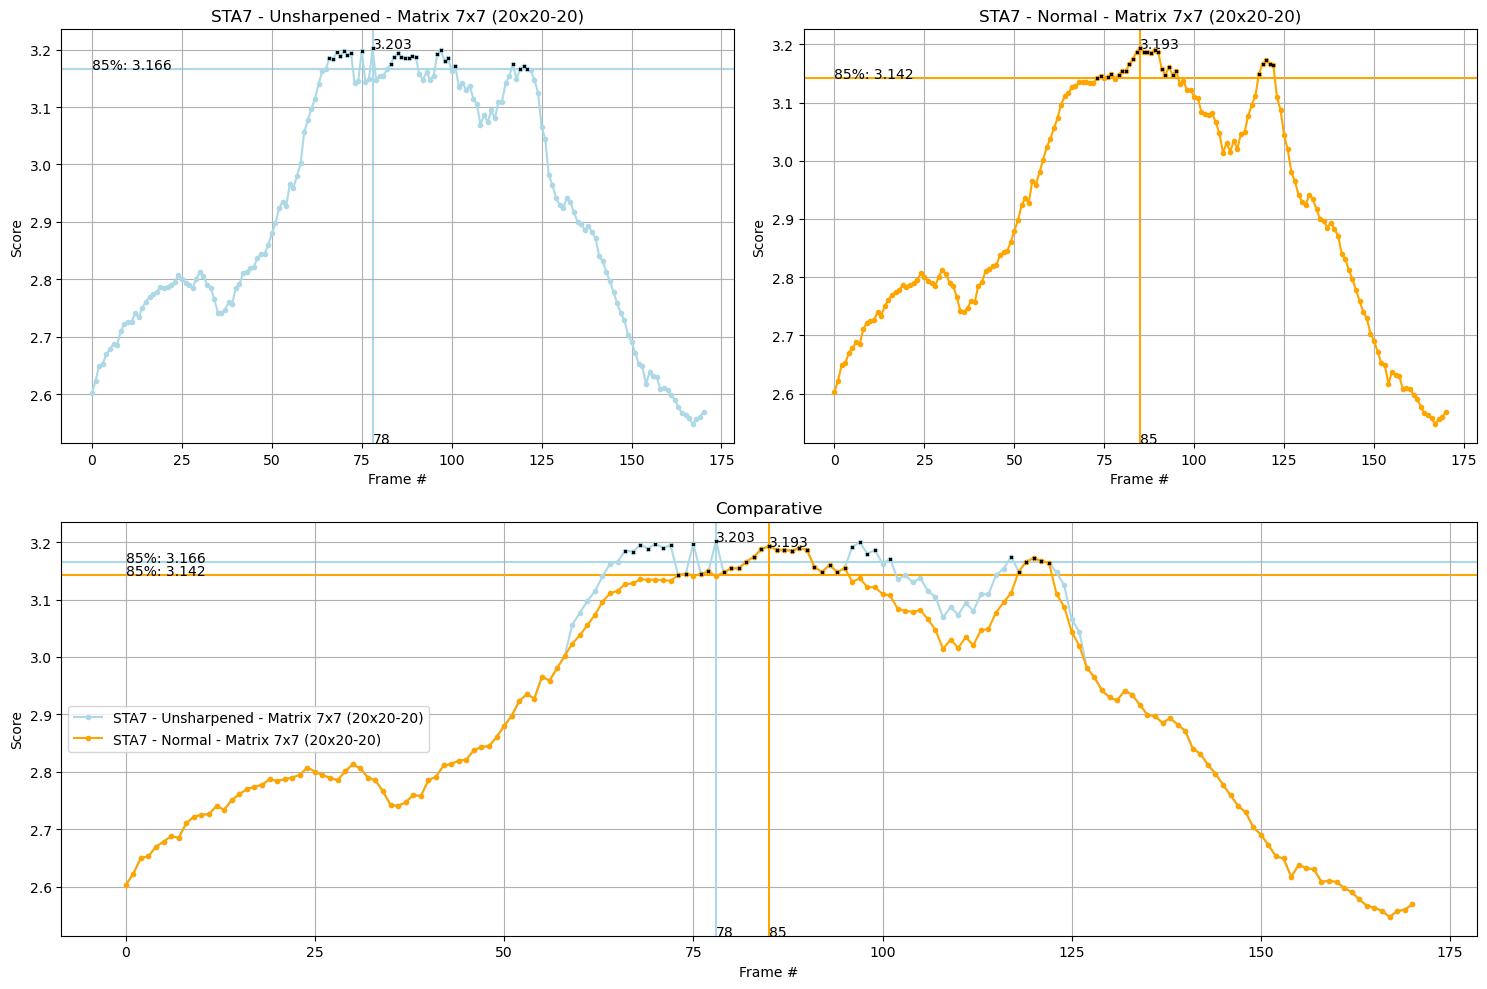

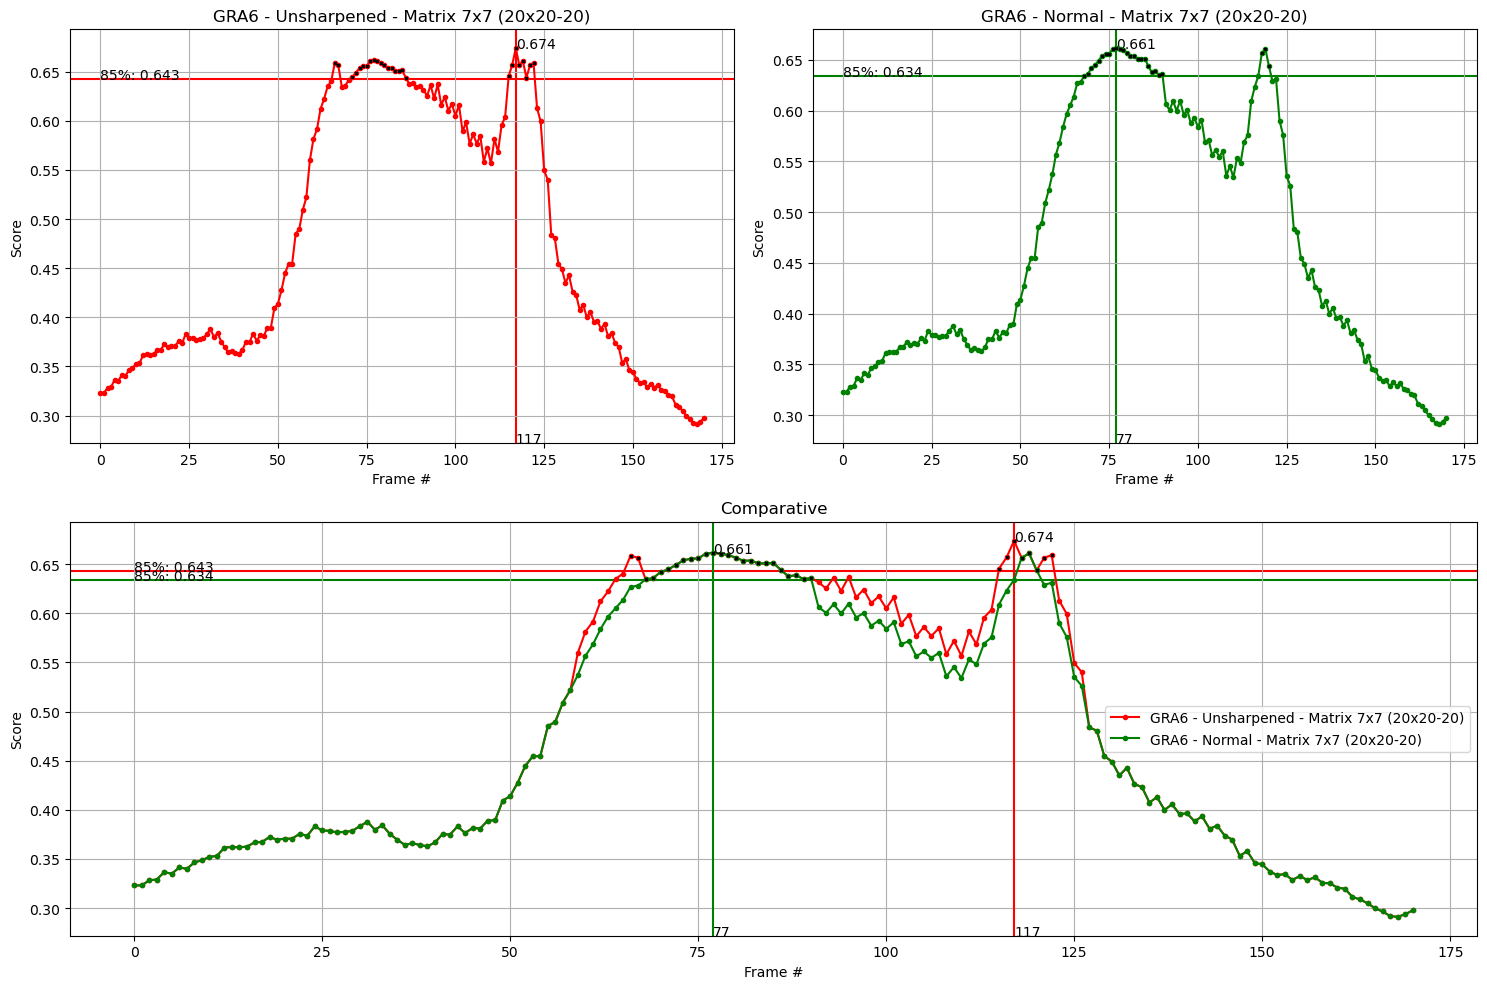

In [40]:
roi_frame_iqm_sta7 = [process_video_enhance(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=7, box_width_px=20, box_height_px=20, space_px=20, measure_func=sta7_measure),
                      process_video(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=7, box_width_px=20, box_height_px=20, space_px=20, measure_func=sta7_measure)]
roi_frame_iqm_gra6 = [process_video_enhance(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=7, box_width_px=20, box_height_px=20, space_px=20, measure_func=sharpness_tenengrad),
                      process_video(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=7, box_width_px=20, box_height_px=20, space_px=20, measure_func=sharpness_tenengrad)]

plot_comparative(roi_frame_iqm_sta7, [r"STA7 - Unsharpened - Matrix 7x7 (20x20-20)", r"STA7 - Normal - Matrix 7x7 (20x20-20)"], [15,10], colors)
plot_comparative(roi_frame_iqm_gra6, [r"GRA6 - Unsharpened - Matrix 7x7 (20x20-20)", r"GRA6 - Normal - Matrix 7x7 (20x20-20)"], [15,10], colors[2:])

[(90, 'GRA6 - Unsharpened - Matrix 9x3 (20x20-20)'),
 (90, 'GRA6 - Normal - Matrix 9x3 (20x20-20)')]

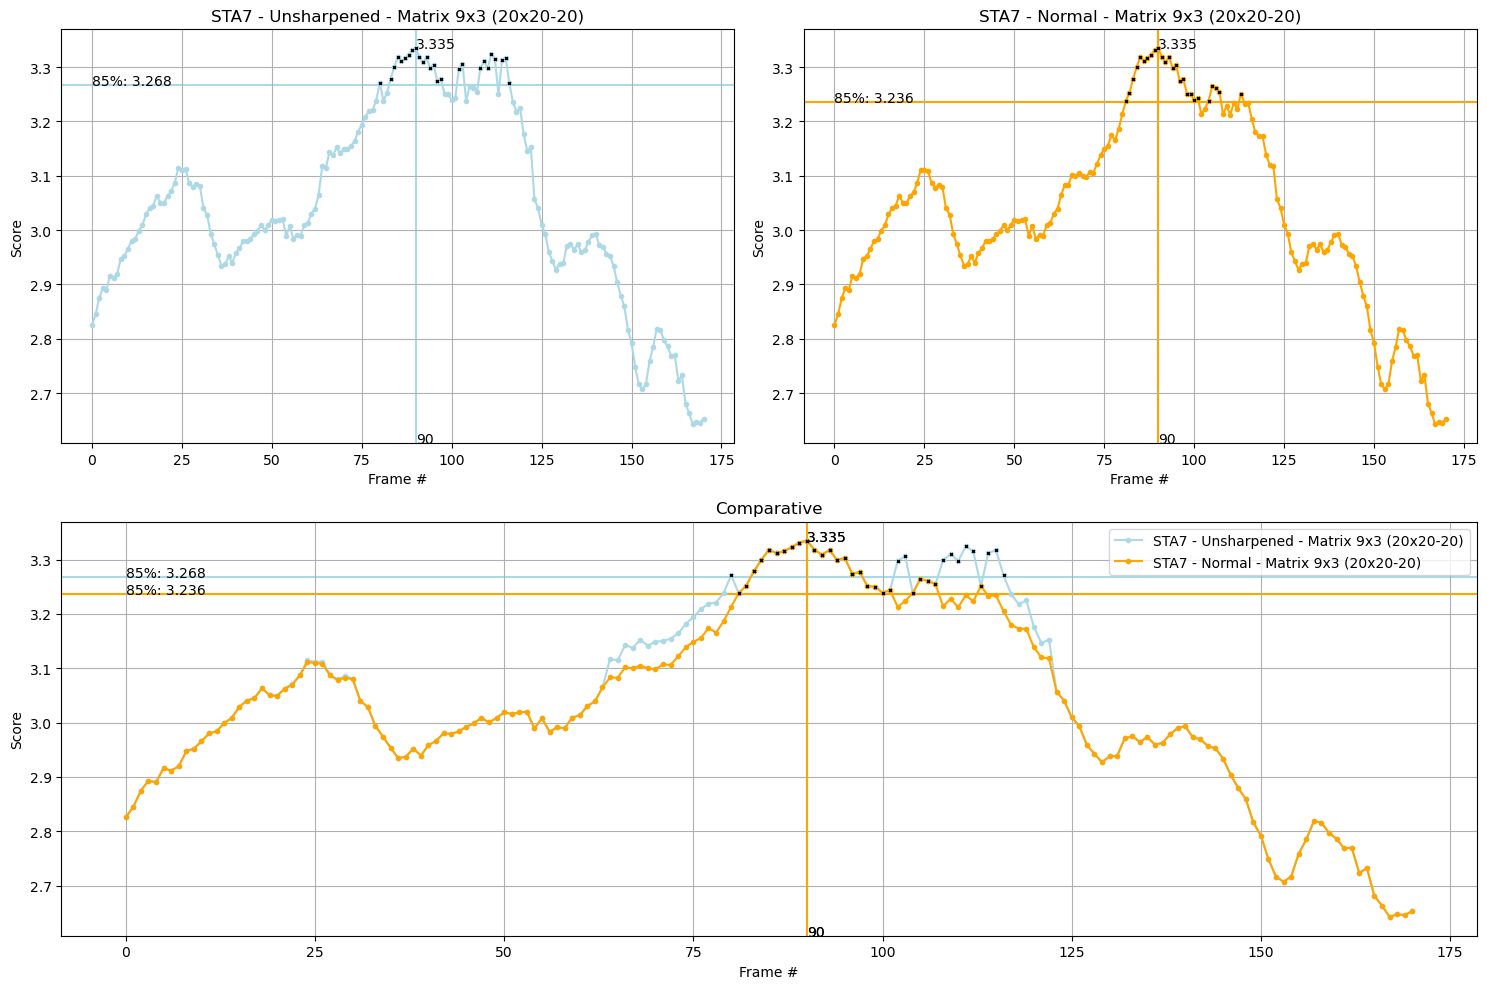

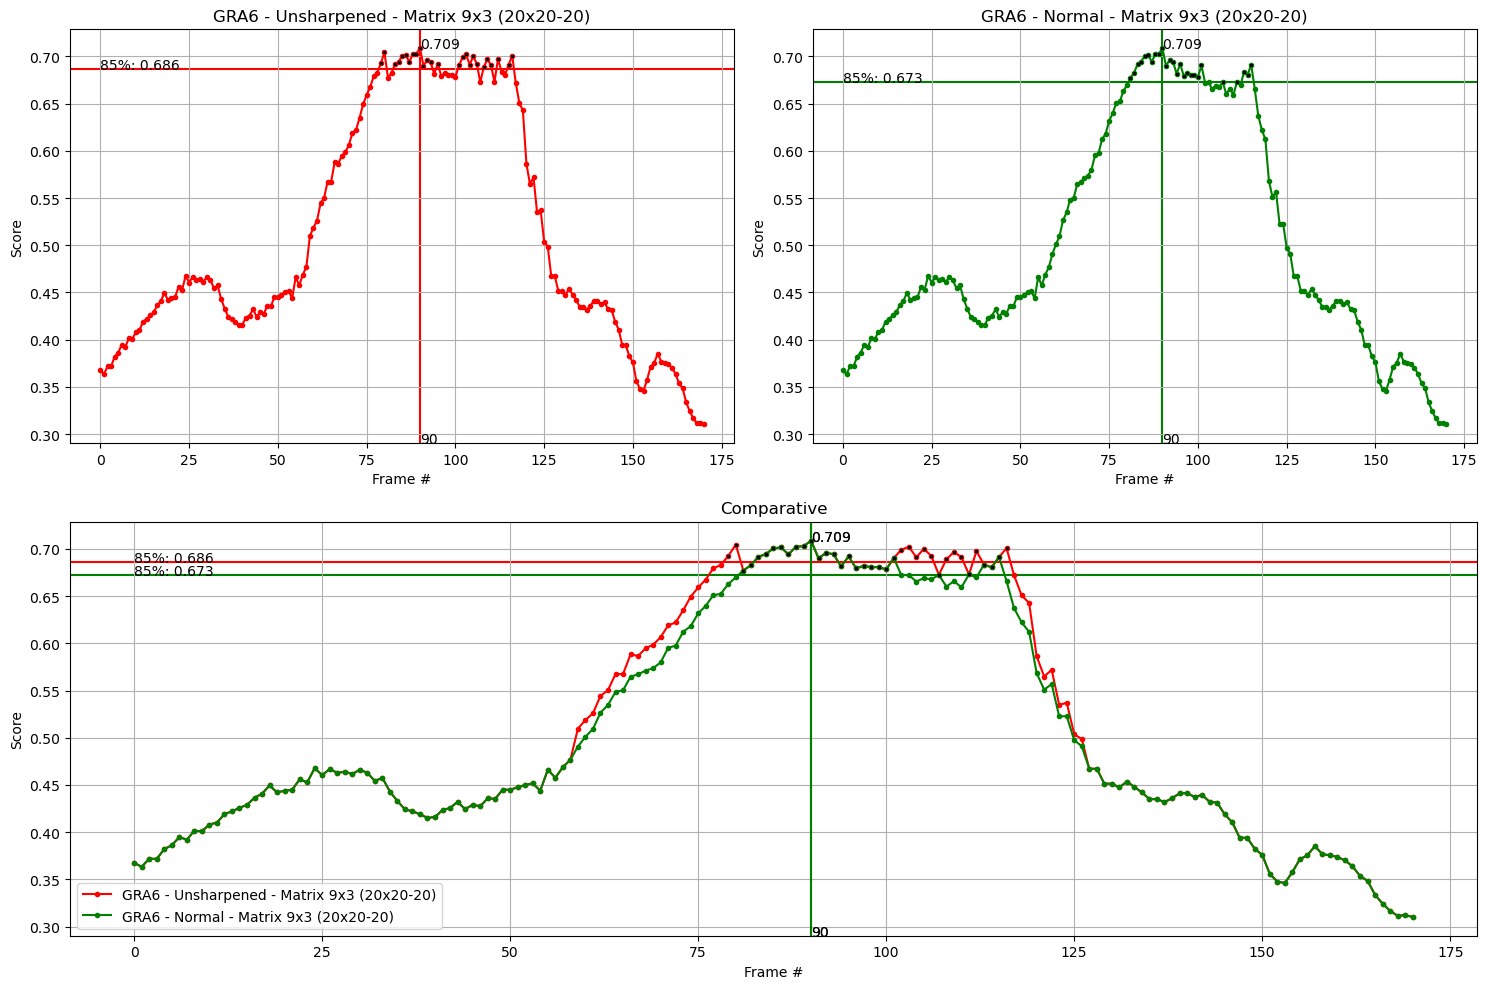

In [41]:
roi_frame_iqm_sta7 = [process_video_enhance(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=sta7_measure),
                      process_video(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=sta7_measure)]
roi_frame_iqm_gra6 = [process_video_enhance(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=sharpness_tenengrad),
                      process_video(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=sharpness_tenengrad)]

plot_comparative(roi_frame_iqm_sta7, [r"STA7 - Unsharpened - Matrix 9x3 (20x20-20)", r"STA7 - Normal - Matrix 9x3 (20x20-20)"], [15,10], colors)
plot_comparative(roi_frame_iqm_gra6, [r"GRA6 - Unsharpened - Matrix 9x3 (20x20-20)", r"GRA6 - Normal - Matrix 9x3 (20x20-20)"], [15,10], colors[2:])

Con unsharp se ve una leve mejora en los gráficos, en algunos incluso la mejora hace que se eleve el top 85% y posiciona algunos nuevos puntos al nivel de los top 85% sin aplicar. 

Realizamos el análisis a ojo sobre el video, y notamos lo siguiente:  

Frame 0: todo muy desenfocado  
Frame 65: la mesa parece enfocada  
Frame 80: el objeto parece bastante enfocado  
Frame 90-112: el objeto esta muy enfocado, la mesa fuera de foco  
Frame 118: el objeto pierde foco, la mesa esta algo enfocada  
Frame 121: objeto desenfocado, mesa apenas enfocada  
Frame 128: todo bastante desenfocado  
Frame 133: todo muy desenfocado  
Frame 170: todo muy desenfocado

Conclusion final:

Repasando la conclusion anterior extraida de los top frames de los gráficos:  
"...podríamos pensar que el foco esta entre los frame 101, ya que 6 de las pruebas coincidieron en ese frame.  El frame que le sigue en cantidad de coincidencias es el 111, con 4 pruebas. Le siguen los frames 91, 109 y 113 con 3 coincidencias y 112 con 2 coincidencias."

Vemos que según el análisis visual, que hay buenas coincidencias con las pruebas realizadas, como para determinar que el mejor foco esta en el frame 101 o entre los frames 109 y 113, lo que varía según el área que analiza cada prueba.

Nota: Sobre los gráficos, cuando se menciona top 85% se hace referencia a los 26 frames con mejor foco, indicados con un punto en cada gráfico.